In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "04"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1639

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.754653	valid_0's recall_at4: 0.608474	valid_0's norm_gini: 0.900833


[100]	valid_0's amex_metric: 0.765227	valid_0's recall_at4: 0.623622	valid_0's norm_gini: 0.906832


[150]	valid_0's amex_metric: 0.772142	valid_0's recall_at4: 0.633847	valid_0's norm_gini: 0.910437


[200]	valid_0's amex_metric: 0.776566	valid_0's recall_at4: 0.63898	valid_0's norm_gini: 0.914153


[250]	valid_0's amex_metric: 0.78052	valid_0's recall_at4: 0.644534	valid_0's norm_gini: 0.916506


[300]	valid_0's amex_metric: 0.783625	valid_0's recall_at4: 0.649078	valid_0's norm_gini: 0.918172


[350]	valid_0's amex_metric: 0.787028	valid_0's recall_at4: 0.654633	valid_0's norm_gini: 0.919424


[400]	valid_0's amex_metric: 0.788435	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.920386


[450]	valid_0's amex_metric: 0.789619	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.921112


[500]	valid_0's amex_metric: 0.790965	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.921658


[550]	valid_0's amex_metric: 0.792187	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.922126


[600]	valid_0's amex_metric: 0.792042	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922466


[650]	valid_0's amex_metric: 0.793296	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.922787


[700]	valid_0's amex_metric: 0.793689	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.923067


[750]	valid_0's amex_metric: 0.794125	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923266


[800]	valid_0's amex_metric: 0.794523	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.923431


[850]	valid_0's amex_metric: 0.795105	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.923711


[900]	valid_0's amex_metric: 0.795199	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.923899


[950]	valid_0's amex_metric: 0.795495	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924114


[1000]	valid_0's amex_metric: 0.796344	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924339


[1050]	valid_0's amex_metric: 0.796741	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924543


[1100]	valid_0's amex_metric: 0.796853	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.924683


[1150]	valid_0's amex_metric: 0.797559	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.924791


[1200]	valid_0's amex_metric: 0.797546	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.924934


[1250]	valid_0's amex_metric: 0.797567	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925016


[1300]	valid_0's amex_metric: 0.798399	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925081


[1350]	valid_0's amex_metric: 0.798124	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925121


[1400]	valid_0's amex_metric: 0.798461	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925206


[1450]	valid_0's amex_metric: 0.798122	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925286


[1500]	valid_0's amex_metric: 0.79809	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925391


[1550]	valid_0's amex_metric: 0.798197	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925478


[1600]	valid_0's amex_metric: 0.798298	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925553


[1650]	valid_0's amex_metric: 0.798519	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925617


[1700]	valid_0's amex_metric: 0.798252	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.925671


[1750]	valid_0's amex_metric: 0.798715	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925714


[1800]	valid_0's amex_metric: 0.79827	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925749


[1850]	valid_0's amex_metric: 0.798693	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925795


[1900]	valid_0's amex_metric: 0.799057	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925852


[1950]	valid_0's amex_metric: 0.79922	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925882


[2000]	valid_0's amex_metric: 0.79944	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925943


[2050]	valid_0's amex_metric: 0.799676	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925953


[2100]	valid_0's amex_metric: 0.79948	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.925981


[2150]	valid_0's amex_metric: 0.80004	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926008


[2200]	valid_0's amex_metric: 0.799814	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.92602


[2250]	valid_0's amex_metric: 0.800184	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.926043


[2300]	valid_0's amex_metric: 0.800056	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926082


[2350]	valid_0's amex_metric: 0.800195	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926107


[2400]	valid_0's amex_metric: 0.800252	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.926138


[2450]	valid_0's amex_metric: 0.800159	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926161


[2500]	valid_0's amex_metric: 0.800005	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.92619


[2550]	valid_0's amex_metric: 0.799862	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926198


[2600]	valid_0's amex_metric: 0.800709	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.926211


[2650]	valid_0's amex_metric: 0.800541	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.92621


[2700]	valid_0's amex_metric: 0.800926	valid_0's recall_at4: 0.675629	valid_0's norm_gini: 0.926222


[2750]	valid_0's amex_metric: 0.800664	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926246


[2800]	valid_0's amex_metric: 0.800482	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.926261


[2850]	valid_0's amex_metric: 0.800555	valid_0's recall_at4: 0.67483	valid_0's norm_gini: 0.92628


[2900]	valid_0's amex_metric: 0.800569	valid_0's recall_at4: 0.67483	valid_0's norm_gini: 0.926308


[2950]	valid_0's amex_metric: 0.800747	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.926328


[3000]	valid_0's amex_metric: 0.800916	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.926328


[3050]	valid_0's amex_metric: 0.800537	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926328


[3100]	valid_0's amex_metric: 0.80057	valid_0's recall_at4: 0.67483	valid_0's norm_gini: 0.92631


[3150]	valid_0's amex_metric: 0.799859	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926318


[3200]	valid_0's amex_metric: 0.800257	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926316


[3250]	valid_0's amex_metric: 0.80019	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926308


[3300]	valid_0's amex_metric: 0.799983	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926315


[3350]	valid_0's amex_metric: 0.800192	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926311


[3400]	valid_0's amex_metric: 0.800173	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926316


[3450]	valid_0's amex_metric: 0.80003	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926324


[3500]	valid_0's amex_metric: 0.8002	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926328


[3550]	valid_0's amex_metric: 0.800159	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.92633


[3600]	valid_0's amex_metric: 0.800054	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.92633


[3650]	valid_0's amex_metric: 0.800169	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.92635


[3700]	valid_0's amex_metric: 0.800295	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926349


[3750]	valid_0's amex_metric: 0.800138	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.92633


[3800]	valid_0's amex_metric: 0.799908	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926333


[3850]	valid_0's amex_metric: 0.799868	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926336


[3900]	valid_0's amex_metric: 0.79996	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926353


[3950]	valid_0's amex_metric: 0.799192	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926373


[4000]	valid_0's amex_metric: 0.799479	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926359


[4050]	valid_0's amex_metric: 0.79918	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926349


[4100]	valid_0's amex_metric: 0.799834	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926352


[4150]	valid_0's amex_metric: 0.799808	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926343


[4200]	valid_0's amex_metric: 0.799364	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926339


[4250]	valid_0's amex_metric: 0.799324	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926344


[4300]	valid_0's amex_metric: 0.799262	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926345


[4350]	valid_0's amex_metric: 0.799391	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926351


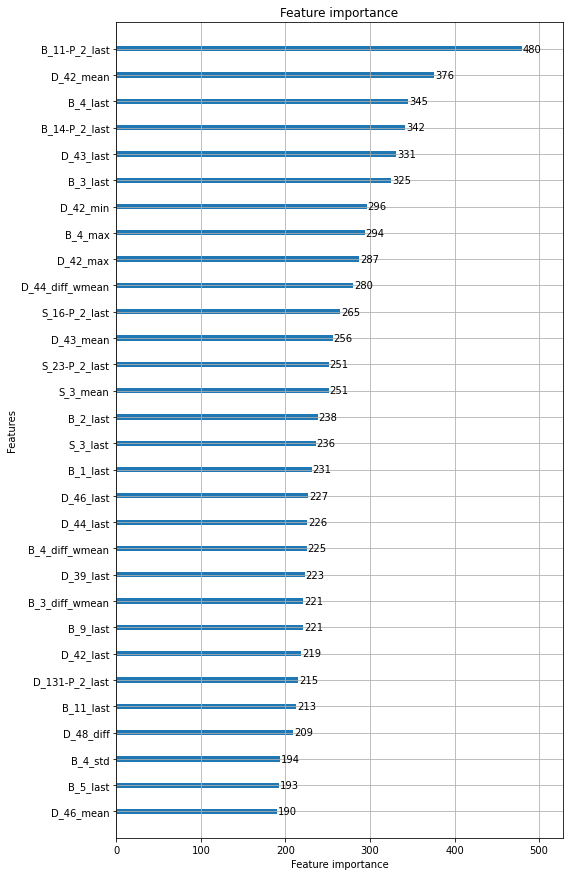

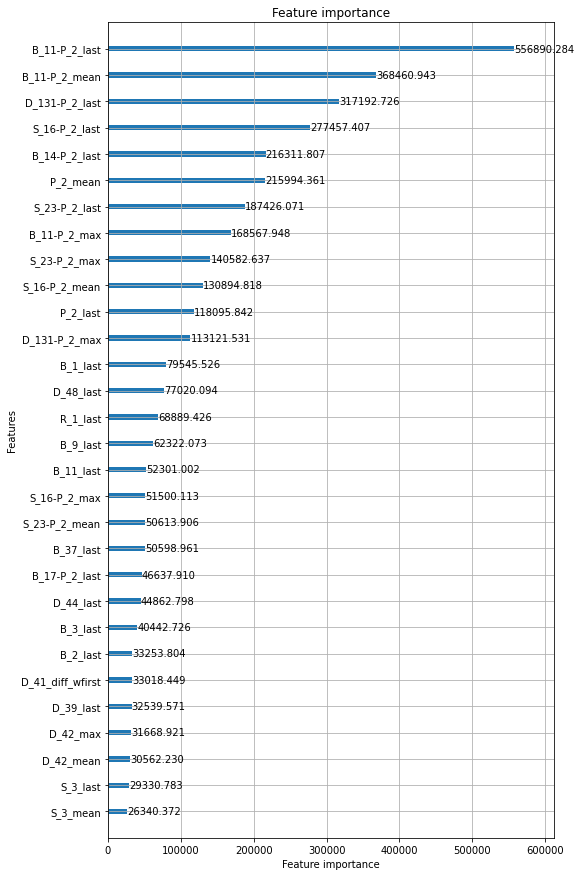

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.749405	valid_0's recall_at4: 0.599217	valid_0's norm_gini: 0.899592


[100]	valid_0's amex_metric: 0.760447	valid_0's recall_at4: 0.615501	valid_0's norm_gini: 0.905392


[150]	valid_0's amex_metric: 0.767039	valid_0's recall_at4: 0.624758	valid_0's norm_gini: 0.90932


[200]	valid_0's amex_metric: 0.77189	valid_0's recall_at4: 0.630985	valid_0's norm_gini: 0.912795


[250]	valid_0's amex_metric: 0.777388	valid_0's recall_at4: 0.639653	valid_0's norm_gini: 0.915122


[300]	valid_0's amex_metric: 0.780407	valid_0's recall_at4: 0.643945	valid_0's norm_gini: 0.916868


[350]	valid_0's amex_metric: 0.782755	valid_0's recall_at4: 0.647395	valid_0's norm_gini: 0.918114


[400]	valid_0's amex_metric: 0.785972	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.91908


[450]	valid_0's amex_metric: 0.787473	valid_0's recall_at4: 0.655096	valid_0's norm_gini: 0.919851


[500]	valid_0's amex_metric: 0.788168	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.920399


[550]	valid_0's amex_metric: 0.788944	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.92094


[600]	valid_0's amex_metric: 0.78971	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.921253


[650]	valid_0's amex_metric: 0.789496	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.921583


[700]	valid_0's amex_metric: 0.790115	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.921895


[750]	valid_0's amex_metric: 0.790731	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.922117


[800]	valid_0's amex_metric: 0.791665	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922344


[850]	valid_0's amex_metric: 0.791588	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922611


[900]	valid_0's amex_metric: 0.79166	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.922796


[950]	valid_0's amex_metric: 0.79303	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923013


[1000]	valid_0's amex_metric: 0.793504	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.923245


[1050]	valid_0's amex_metric: 0.794019	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.923474


[1100]	valid_0's amex_metric: 0.795174	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.923682


[1150]	valid_0's amex_metric: 0.795684	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.923859


[1200]	valid_0's amex_metric: 0.795798	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924003


[1250]	valid_0's amex_metric: 0.796085	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.924116


[1300]	valid_0's amex_metric: 0.796281	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924212


[1350]	valid_0's amex_metric: 0.796179	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.92426


[1400]	valid_0's amex_metric: 0.796797	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.924319


[1450]	valid_0's amex_metric: 0.796748	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.924389


[1500]	valid_0's amex_metric: 0.797112	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.924487


[1550]	valid_0's amex_metric: 0.797302	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924571


[1600]	valid_0's amex_metric: 0.796653	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.92462


[1650]	valid_0's amex_metric: 0.79712	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.924712


[1700]	valid_0's amex_metric: 0.797143	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924799


[1750]	valid_0's amex_metric: 0.796963	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.924861


[1800]	valid_0's amex_metric: 0.797036	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.924922


[1850]	valid_0's amex_metric: 0.797669	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.924969


[1900]	valid_0's amex_metric: 0.797488	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925027


[1950]	valid_0's amex_metric: 0.79756	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925088


[2000]	valid_0's amex_metric: 0.797557	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925123


[2050]	valid_0's amex_metric: 0.797711	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925179


[2100]	valid_0's amex_metric: 0.79773	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925218


[2150]	valid_0's amex_metric: 0.798075	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925276


[2200]	valid_0's amex_metric: 0.798385	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925306


[2250]	valid_0's amex_metric: 0.798634	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925342


[2300]	valid_0's amex_metric: 0.798772	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925366


[2350]	valid_0's amex_metric: 0.798621	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925401


[2400]	valid_0's amex_metric: 0.798876	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925446


[2450]	valid_0's amex_metric: 0.799199	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925461


[2500]	valid_0's amex_metric: 0.799608	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.92548


[2550]	valid_0's amex_metric: 0.798849	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925477


[2600]	valid_0's amex_metric: 0.798841	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925461


[2650]	valid_0's amex_metric: 0.798814	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925492


[2700]	valid_0's amex_metric: 0.798997	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925521


[2750]	valid_0's amex_metric: 0.79923	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925523


[2800]	valid_0's amex_metric: 0.798794	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925535


[2850]	valid_0's amex_metric: 0.799014	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925555


[2900]	valid_0's amex_metric: 0.798661	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.925564


[2950]	valid_0's amex_metric: 0.798415	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925576


[3000]	valid_0's amex_metric: 0.798376	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925583


[3050]	valid_0's amex_metric: 0.79827	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925581


[3100]	valid_0's amex_metric: 0.798125	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925586


[3150]	valid_0's amex_metric: 0.798128	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925593


[3200]	valid_0's amex_metric: 0.798579	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.92561


[3250]	valid_0's amex_metric: 0.797916	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.92563


[3300]	valid_0's amex_metric: 0.79848	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925622


[3350]	valid_0's amex_metric: 0.798123	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925624


[3400]	valid_0's amex_metric: 0.798573	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925641


[3450]	valid_0's amex_metric: 0.798044	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925634


[3500]	valid_0's amex_metric: 0.798089	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.92564


[3550]	valid_0's amex_metric: 0.798329	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925657


[3600]	valid_0's amex_metric: 0.798127	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925674


[3650]	valid_0's amex_metric: 0.797836	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925682


[3700]	valid_0's amex_metric: 0.797996	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925707


[3750]	valid_0's amex_metric: 0.798076	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925697


[3800]	valid_0's amex_metric: 0.79804	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925711


[3850]	valid_0's amex_metric: 0.797861	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.92569


[3900]	valid_0's amex_metric: 0.797435	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925678


[3950]	valid_0's amex_metric: 0.797625	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925681


[4000]	valid_0's amex_metric: 0.798232	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925674


[4050]	valid_0's amex_metric: 0.797731	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925682


[4100]	valid_0's amex_metric: 0.797885	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925695


[4150]	valid_0's amex_metric: 0.798196	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925687


[4200]	valid_0's amex_metric: 0.797935	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925669


[4250]	valid_0's amex_metric: 0.798007	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925687


[4300]	valid_0's amex_metric: 0.798401	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925717


[4350]	valid_0's amex_metric: 0.797925	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925734


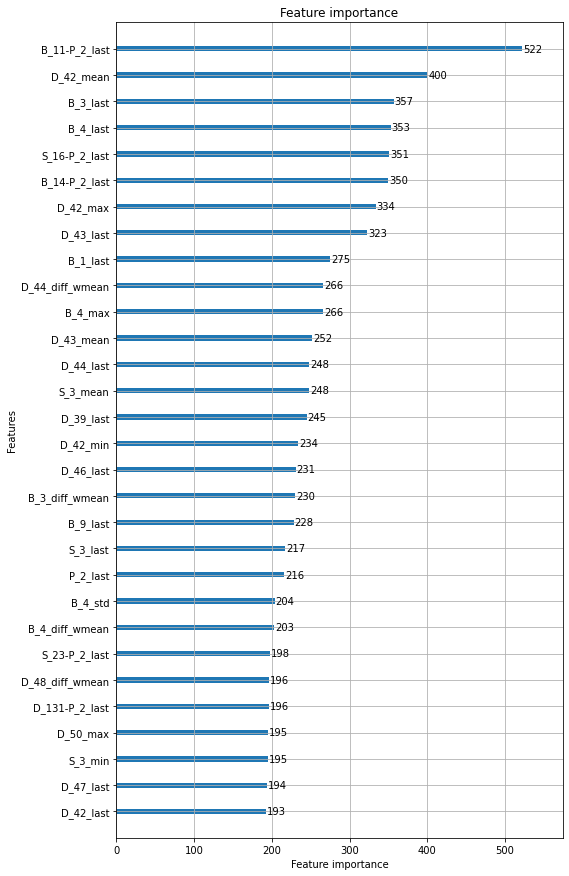

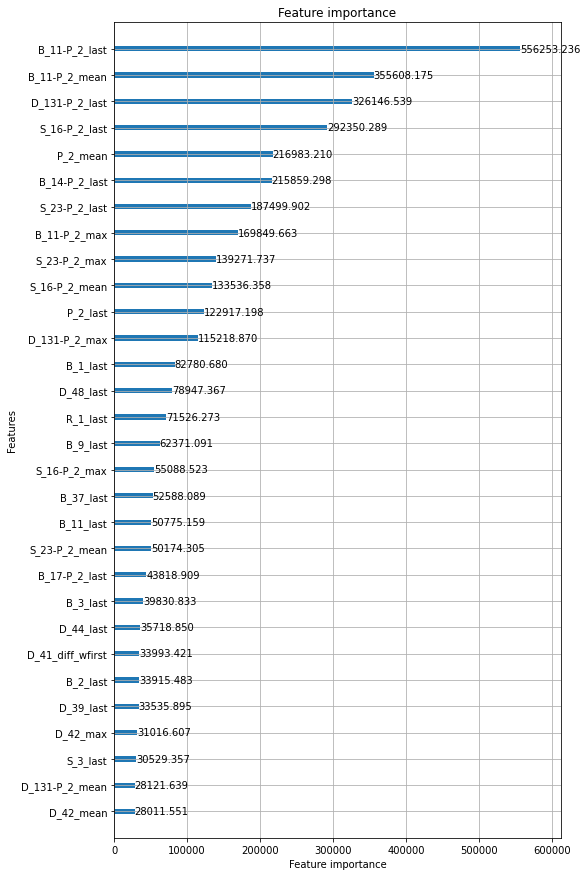

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.747996	valid_0's recall_at4: 0.597029	valid_0's norm_gini: 0.898963


[100]	valid_0's amex_metric: 0.757904	valid_0's recall_at4: 0.611041	valid_0's norm_gini: 0.904767


[150]	valid_0's amex_metric: 0.762096	valid_0's recall_at4: 0.615712	valid_0's norm_gini: 0.908481


[200]	valid_0's amex_metric: 0.769132	valid_0's recall_at4: 0.626273	valid_0's norm_gini: 0.911991


[250]	valid_0's amex_metric: 0.773158	valid_0's recall_at4: 0.632164	valid_0's norm_gini: 0.914152


[300]	valid_0's amex_metric: 0.776502	valid_0's recall_at4: 0.637297	valid_0's norm_gini: 0.915707


[350]	valid_0's amex_metric: 0.778295	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.916852


[400]	valid_0's amex_metric: 0.781249	valid_0's recall_at4: 0.644702	valid_0's norm_gini: 0.917796


[450]	valid_0's amex_metric: 0.782197	valid_0's recall_at4: 0.645839	valid_0's norm_gini: 0.918556


[500]	valid_0's amex_metric: 0.783237	valid_0's recall_at4: 0.647353	valid_0's norm_gini: 0.91912


[550]	valid_0's amex_metric: 0.783614	valid_0's recall_at4: 0.647648	valid_0's norm_gini: 0.919581


[600]	valid_0's amex_metric: 0.784343	valid_0's recall_at4: 0.648784	valid_0's norm_gini: 0.919902


[650]	valid_0's amex_metric: 0.785664	valid_0's recall_at4: 0.651098	valid_0's norm_gini: 0.92023


[700]	valid_0's amex_metric: 0.786234	valid_0's recall_at4: 0.651898	valid_0's norm_gini: 0.920571


[750]	valid_0's amex_metric: 0.786841	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.920816


[800]	valid_0's amex_metric: 0.786993	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.920995


[850]	valid_0's amex_metric: 0.787371	valid_0's recall_at4: 0.653497	valid_0's norm_gini: 0.921245


[900]	valid_0's amex_metric: 0.788183	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.92144


[950]	valid_0's amex_metric: 0.787977	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.921658


[1000]	valid_0's amex_metric: 0.787894	valid_0's recall_at4: 0.653959	valid_0's norm_gini: 0.921828


[1050]	valid_0's amex_metric: 0.788596	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.922054


[1100]	valid_0's amex_metric: 0.789436	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922305


[1150]	valid_0's amex_metric: 0.789599	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.922461


[1200]	valid_0's amex_metric: 0.79025	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.922585


[1250]	valid_0's amex_metric: 0.790289	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.922706


[1300]	valid_0's amex_metric: 0.790102	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922795


[1350]	valid_0's amex_metric: 0.790708	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.92287


[1400]	valid_0's amex_metric: 0.790253	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.922927


[1450]	valid_0's amex_metric: 0.790909	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.923019


[1500]	valid_0's amex_metric: 0.790513	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.923069


[1550]	valid_0's amex_metric: 0.790549	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.923141


[1600]	valid_0's amex_metric: 0.791068	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.923211


[1650]	valid_0's amex_metric: 0.791692	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923282


[1700]	valid_0's amex_metric: 0.791372	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.923316


[1750]	valid_0's amex_metric: 0.791292	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.923366


[1800]	valid_0's amex_metric: 0.791536	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923391


[1850]	valid_0's amex_metric: 0.791917	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.92348


[1900]	valid_0's amex_metric: 0.791884	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.923498


[1950]	valid_0's amex_metric: 0.791506	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.92354


[2000]	valid_0's amex_metric: 0.79159	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.923583


[2050]	valid_0's amex_metric: 0.792244	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.923627


[2100]	valid_0's amex_metric: 0.791887	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923671


[2150]	valid_0's amex_metric: 0.792371	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923714


[2200]	valid_0's amex_metric: 0.79155	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.923754


[2250]	valid_0's amex_metric: 0.791962	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.92378


[2300]	valid_0's amex_metric: 0.79212	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.923801


[2350]	valid_0's amex_metric: 0.791973	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923844


[2400]	valid_0's amex_metric: 0.792217	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923868


[2450]	valid_0's amex_metric: 0.792392	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923882


[2500]	valid_0's amex_metric: 0.792366	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.923913


[2550]	valid_0's amex_metric: 0.792782	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923947


[2600]	valid_0's amex_metric: 0.792497	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923965


[2650]	valid_0's amex_metric: 0.792462	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.92398


[2700]	valid_0's amex_metric: 0.792509	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923989


[2750]	valid_0's amex_metric: 0.792459	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.924016


[2800]	valid_0's amex_metric: 0.792737	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.924024


[2850]	valid_0's amex_metric: 0.792438	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.924057


[2900]	valid_0's amex_metric: 0.792639	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.924082


[2950]	valid_0's amex_metric: 0.792189	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.924107


[3000]	valid_0's amex_metric: 0.79252	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.924137


[3050]	valid_0's amex_metric: 0.792729	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924136


[3100]	valid_0's amex_metric: 0.79305	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924146


[3150]	valid_0's amex_metric: 0.792844	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.924155


[3200]	valid_0's amex_metric: 0.793152	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.924139


[3250]	valid_0's amex_metric: 0.792985	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924142


[3300]	valid_0's amex_metric: 0.793209	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.92417


[3350]	valid_0's amex_metric: 0.793573	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924183


[3400]	valid_0's amex_metric: 0.793472	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.924191


[3450]	valid_0's amex_metric: 0.793247	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924203


[3500]	valid_0's amex_metric: 0.792922	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924227


[3550]	valid_0's amex_metric: 0.793354	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924249


[3600]	valid_0's amex_metric: 0.793211	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.924257


[3650]	valid_0's amex_metric: 0.793003	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924262


[3700]	valid_0's amex_metric: 0.793328	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.92428


[3750]	valid_0's amex_metric: 0.793457	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924286


[3800]	valid_0's amex_metric: 0.79323	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.924296


[3850]	valid_0's amex_metric: 0.793279	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924309


[3900]	valid_0's amex_metric: 0.793445	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.924305


[3950]	valid_0's amex_metric: 0.793664	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924281


[4000]	valid_0's amex_metric: 0.793364	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.92427


[4050]	valid_0's amex_metric: 0.793361	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924263


[4100]	valid_0's amex_metric: 0.793463	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924257


[4150]	valid_0's amex_metric: 0.793099	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924243


[4200]	valid_0's amex_metric: 0.792935	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924252


[4250]	valid_0's amex_metric: 0.792931	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924244


[4300]	valid_0's amex_metric: 0.792818	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924228


[4350]	valid_0's amex_metric: 0.792795	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.924224


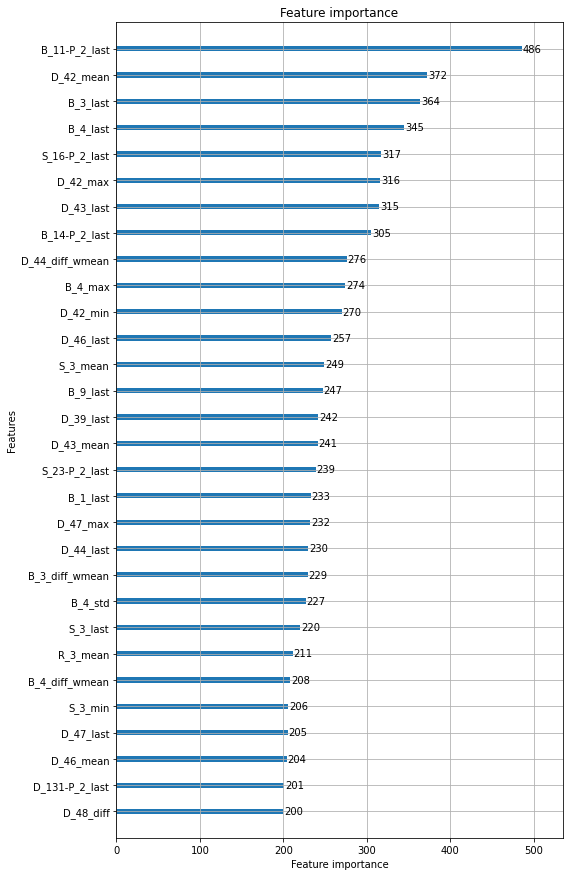

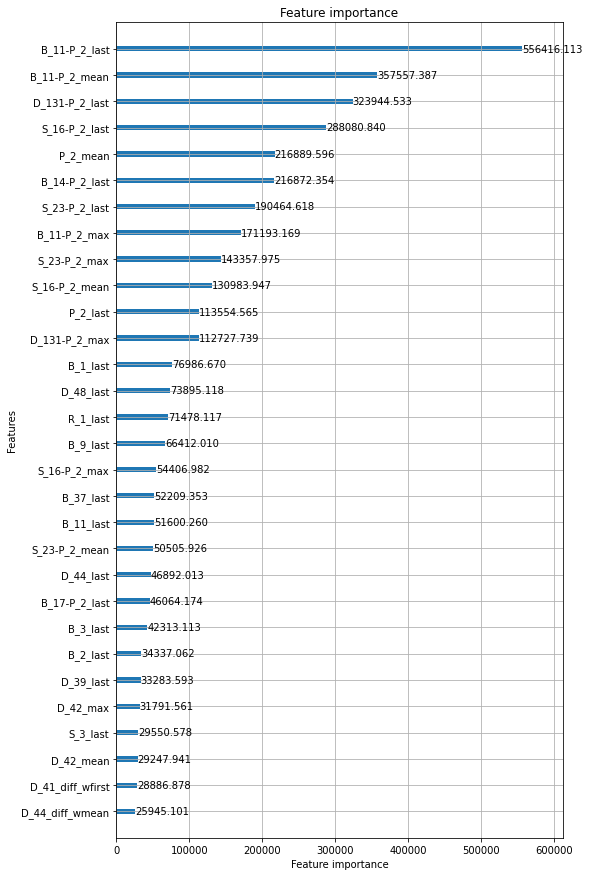

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.74599	valid_0's recall_at4: 0.593983	valid_0's norm_gini: 0.897997


[100]	valid_0's amex_metric: 0.755843	valid_0's recall_at4: 0.607532	valid_0's norm_gini: 0.904154


[150]	valid_0's amex_metric: 0.763346	valid_0's recall_at4: 0.618725	valid_0's norm_gini: 0.907967


[200]	valid_0's amex_metric: 0.769953	valid_0's recall_at4: 0.628277	valid_0's norm_gini: 0.911629


[250]	valid_0's amex_metric: 0.772971	valid_0's recall_at4: 0.632064	valid_0's norm_gini: 0.913879


[300]	valid_0's amex_metric: 0.776134	valid_0's recall_at4: 0.636651	valid_0's norm_gini: 0.915618


[350]	valid_0's amex_metric: 0.778529	valid_0's recall_at4: 0.640101	valid_0's norm_gini: 0.916957


[400]	valid_0's amex_metric: 0.780304	valid_0's recall_at4: 0.642626	valid_0's norm_gini: 0.917983


[450]	valid_0's amex_metric: 0.781305	valid_0's recall_at4: 0.643804	valid_0's norm_gini: 0.918806


[500]	valid_0's amex_metric: 0.782105	valid_0's recall_at4: 0.644772	valid_0's norm_gini: 0.919439


[550]	valid_0's amex_metric: 0.782836	valid_0's recall_at4: 0.64574	valid_0's norm_gini: 0.919932


[600]	valid_0's amex_metric: 0.783619	valid_0's recall_at4: 0.64696	valid_0's norm_gini: 0.920277


[650]	valid_0's amex_metric: 0.784759	valid_0's recall_at4: 0.648895	valid_0's norm_gini: 0.920624


[700]	valid_0's amex_metric: 0.784628	valid_0's recall_at4: 0.648306	valid_0's norm_gini: 0.92095


[750]	valid_0's amex_metric: 0.785293	valid_0's recall_at4: 0.6494	valid_0's norm_gini: 0.921186


[800]	valid_0's amex_metric: 0.786485	valid_0's recall_at4: 0.651546	valid_0's norm_gini: 0.921424


[850]	valid_0's amex_metric: 0.787047	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.921707


[900]	valid_0's amex_metric: 0.787371	valid_0's recall_at4: 0.652851	valid_0's norm_gini: 0.92189


[950]	valid_0's amex_metric: 0.787311	valid_0's recall_at4: 0.652472	valid_0's norm_gini: 0.92215


[1000]	valid_0's amex_metric: 0.78737	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.922352


[1050]	valid_0's amex_metric: 0.78777	valid_0's recall_at4: 0.652893	valid_0's norm_gini: 0.922647


[1100]	valid_0's amex_metric: 0.789151	valid_0's recall_at4: 0.655418	valid_0's norm_gini: 0.922884


[1150]	valid_0's amex_metric: 0.789834	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923073


[1200]	valid_0's amex_metric: 0.790226	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.923183


[1250]	valid_0's amex_metric: 0.790036	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.923307


[1300]	valid_0's amex_metric: 0.789778	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.92338


[1350]	valid_0's amex_metric: 0.789753	valid_0's recall_at4: 0.656091	valid_0's norm_gini: 0.923415


[1400]	valid_0's amex_metric: 0.789814	valid_0's recall_at4: 0.656133	valid_0's norm_gini: 0.923495


[1450]	valid_0's amex_metric: 0.790023	valid_0's recall_at4: 0.65647	valid_0's norm_gini: 0.923577


[1500]	valid_0's amex_metric: 0.790204	valid_0's recall_at4: 0.656722	valid_0's norm_gini: 0.923686


[1550]	valid_0's amex_metric: 0.790546	valid_0's recall_at4: 0.657311	valid_0's norm_gini: 0.923781


[1600]	valid_0's amex_metric: 0.790214	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923832


[1650]	valid_0's amex_metric: 0.790433	valid_0's recall_at4: 0.656975	valid_0's norm_gini: 0.92389


[1700]	valid_0's amex_metric: 0.790254	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923911


[1750]	valid_0's amex_metric: 0.790485	valid_0's recall_at4: 0.656975	valid_0's norm_gini: 0.923996


[1800]	valid_0's amex_metric: 0.790482	valid_0's recall_at4: 0.656932	valid_0's norm_gini: 0.924032


[1850]	valid_0's amex_metric: 0.790441	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.924077


[1900]	valid_0's amex_metric: 0.790611	valid_0's recall_at4: 0.657101	valid_0's norm_gini: 0.92412


[1950]	valid_0's amex_metric: 0.790605	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.924193


[2000]	valid_0's amex_metric: 0.7912	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.924206


[2050]	valid_0's amex_metric: 0.791244	valid_0's recall_at4: 0.658237	valid_0's norm_gini: 0.92425


[2100]	valid_0's amex_metric: 0.79117	valid_0's recall_at4: 0.658027	valid_0's norm_gini: 0.924314


[2150]	valid_0's amex_metric: 0.79153	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.924361


[2200]	valid_0's amex_metric: 0.791562	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924381


[2250]	valid_0's amex_metric: 0.791603	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.924422


[2300]	valid_0's amex_metric: 0.791724	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.924454


[2350]	valid_0's amex_metric: 0.791581	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.924463


[2400]	valid_0's amex_metric: 0.791388	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.924497


[2450]	valid_0's amex_metric: 0.791722	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924534


[2500]	valid_0's amex_metric: 0.791529	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.924569


[2550]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924591


[2600]	valid_0's amex_metric: 0.791922	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924596


[2650]	valid_0's amex_metric: 0.792009	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.924645


[2700]	valid_0's amex_metric: 0.791696	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924649


[2750]	valid_0's amex_metric: 0.79148	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.92468


[2800]	valid_0's amex_metric: 0.791591	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.924693


[2850]	valid_0's amex_metric: 0.791724	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924706


[2900]	valid_0's amex_metric: 0.79175	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.924717


[2950]	valid_0's amex_metric: 0.791623	valid_0's recall_at4: 0.658531	valid_0's norm_gini: 0.924714


[3000]	valid_0's amex_metric: 0.791701	valid_0's recall_at4: 0.658658	valid_0's norm_gini: 0.924744


[3050]	valid_0's amex_metric: 0.791689	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.924763


[3100]	valid_0's amex_metric: 0.791941	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924761


[3150]	valid_0's amex_metric: 0.791605	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924763


[3200]	valid_0's amex_metric: 0.792069	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.924766


[3250]	valid_0's amex_metric: 0.792357	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924752


[3300]	valid_0's amex_metric: 0.792131	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.924762


[3350]	valid_0's amex_metric: 0.792152	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.924762


[3400]	valid_0's amex_metric: 0.792632	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924756


[3450]	valid_0's amex_metric: 0.792593	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924762


[3500]	valid_0's amex_metric: 0.792639	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924769


[3550]	valid_0's amex_metric: 0.79251	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.924764


[3600]	valid_0's amex_metric: 0.791951	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924781


[3650]	valid_0's amex_metric: 0.792359	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.924798


[3700]	valid_0's amex_metric: 0.792645	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924822


[3750]	valid_0's amex_metric: 0.792827	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.924808


[3800]	valid_0's amex_metric: 0.79281	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924816


[3850]	valid_0's amex_metric: 0.792414	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.924823


[3900]	valid_0's amex_metric: 0.792752	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.924827


[3950]	valid_0's amex_metric: 0.79263	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924835


[4000]	valid_0's amex_metric: 0.792973	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.924849


[4050]	valid_0's amex_metric: 0.792831	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924858


[4100]	valid_0's amex_metric: 0.792659	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924851


[4150]	valid_0's amex_metric: 0.792527	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.924839


[4200]	valid_0's amex_metric: 0.79244	valid_0's recall_at4: 0.660046	valid_0's norm_gini: 0.924834


[4250]	valid_0's amex_metric: 0.792456	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.924824


[4300]	valid_0's amex_metric: 0.792529	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.924844


[4350]	valid_0's amex_metric: 0.792557	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.924858


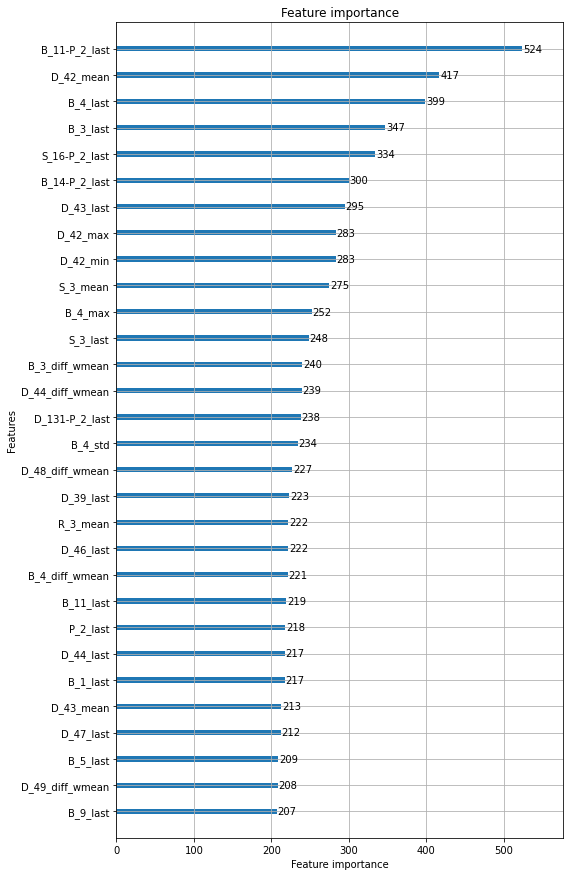

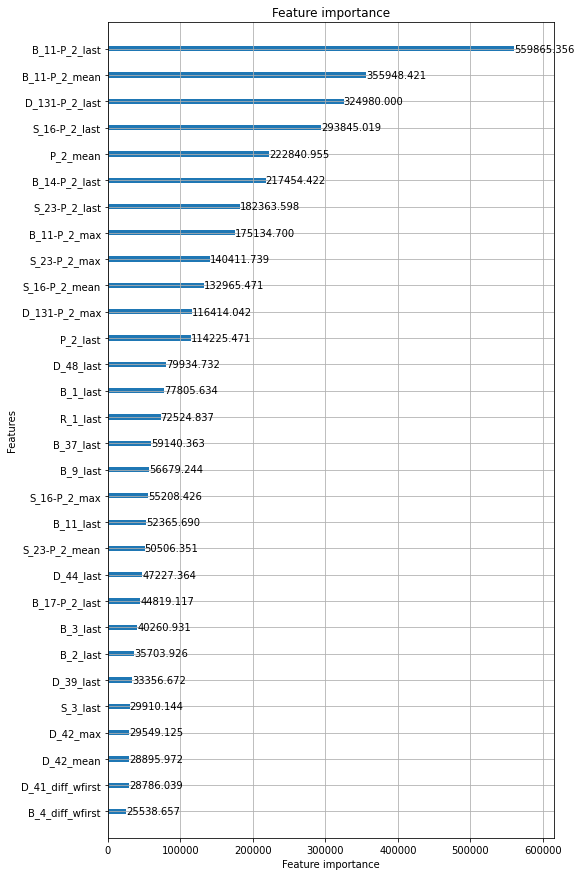

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.755078	valid_0's recall_at4: 0.608121	valid_0's norm_gini: 0.902034


[100]	valid_0's amex_metric: 0.764928	valid_0's recall_at4: 0.621797	valid_0's norm_gini: 0.908059


[150]	valid_0's amex_metric: 0.772189	valid_0's recall_at4: 0.632569	valid_0's norm_gini: 0.911809


[200]	valid_0's amex_metric: 0.777704	valid_0's recall_at4: 0.640143	valid_0's norm_gini: 0.915265


[250]	valid_0's amex_metric: 0.781795	valid_0's recall_at4: 0.646034	valid_0's norm_gini: 0.917556


[300]	valid_0's amex_metric: 0.785223	valid_0's recall_at4: 0.651252	valid_0's norm_gini: 0.919193


[350]	valid_0's amex_metric: 0.787193	valid_0's recall_at4: 0.653987	valid_0's norm_gini: 0.9204


[400]	valid_0's amex_metric: 0.789764	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.921417


[450]	valid_0's amex_metric: 0.791832	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.922104


[500]	valid_0's amex_metric: 0.79296	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.922634


[550]	valid_0's amex_metric: 0.793762	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.923101


[600]	valid_0's amex_metric: 0.793046	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.923394


[650]	valid_0's amex_metric: 0.794627	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.923738


[700]	valid_0's amex_metric: 0.794943	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924033


[750]	valid_0's amex_metric: 0.795344	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924287


[800]	valid_0's amex_metric: 0.795593	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.924491


[850]	valid_0's amex_metric: 0.795839	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.92473


[900]	valid_0's amex_metric: 0.796396	valid_0's recall_at4: 0.667873	valid_0's norm_gini: 0.924919


[950]	valid_0's amex_metric: 0.796864	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.92514


[1000]	valid_0's amex_metric: 0.796909	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925357


[1050]	valid_0's amex_metric: 0.797836	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925568


[1100]	valid_0's amex_metric: 0.798503	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.925724


[1150]	valid_0's amex_metric: 0.798828	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.925911


[1200]	valid_0's amex_metric: 0.798654	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.926027


[1250]	valid_0's amex_metric: 0.799112	valid_0's recall_at4: 0.672123	valid_0's norm_gini: 0.926102


[1300]	valid_0's amex_metric: 0.799596	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.926186


[1350]	valid_0's amex_metric: 0.799448	valid_0's recall_at4: 0.672628	valid_0's norm_gini: 0.926268


[1400]	valid_0's amex_metric: 0.800116	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.926342


[1450]	valid_0's amex_metric: 0.799917	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926407


[1500]	valid_0's amex_metric: 0.800486	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.926494


[1550]	valid_0's amex_metric: 0.800703	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.92659


[1600]	valid_0's amex_metric: 0.800948	valid_0's recall_at4: 0.675237	valid_0's norm_gini: 0.926659


[1650]	valid_0's amex_metric: 0.80049	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.92671


[1700]	valid_0's amex_metric: 0.800902	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.926778


[1750]	valid_0's amex_metric: 0.800938	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.92685


[1800]	valid_0's amex_metric: 0.801276	valid_0's recall_at4: 0.675657	valid_0's norm_gini: 0.926895


[1850]	valid_0's amex_metric: 0.801826	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.926942


[1900]	valid_0's amex_metric: 0.801892	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.926991


[1950]	valid_0's amex_metric: 0.801807	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.92703


[2000]	valid_0's amex_metric: 0.801701	valid_0's recall_at4: 0.676331	valid_0's norm_gini: 0.92707


[2050]	valid_0's amex_metric: 0.801522	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927092


[2100]	valid_0's amex_metric: 0.801414	valid_0's recall_at4: 0.675657	valid_0's norm_gini: 0.92717


[2150]	valid_0's amex_metric: 0.802422	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927209


[2200]	valid_0's amex_metric: 0.802442	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927248


[2250]	valid_0's amex_metric: 0.802157	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.927268


[2300]	valid_0's amex_metric: 0.801926	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927268


[2350]	valid_0's amex_metric: 0.801977	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.927287


[2400]	valid_0's amex_metric: 0.80204	valid_0's recall_at4: 0.676752	valid_0's norm_gini: 0.927329


[2450]	valid_0's amex_metric: 0.80214	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.92736


[2500]	valid_0's amex_metric: 0.802511	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927387


[2550]	valid_0's amex_metric: 0.802538	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.927399


[2600]	valid_0's amex_metric: 0.802794	valid_0's recall_at4: 0.678182	valid_0's norm_gini: 0.927405


[2650]	valid_0's amex_metric: 0.802539	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927442


[2700]	valid_0's amex_metric: 0.802605	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.927449


[2750]	valid_0's amex_metric: 0.802375	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.92745


[2800]	valid_0's amex_metric: 0.802125	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927457


[2850]	valid_0's amex_metric: 0.802728	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.927484


[2900]	valid_0's amex_metric: 0.802558	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.92748


[2950]	valid_0's amex_metric: 0.8021	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.92749


[3000]	valid_0's amex_metric: 0.801747	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.9275


[3050]	valid_0's amex_metric: 0.802164	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927534


[3100]	valid_0's amex_metric: 0.802421	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.927544


[3150]	valid_0's amex_metric: 0.802372	valid_0's recall_at4: 0.677172	valid_0's norm_gini: 0.927571


[3200]	valid_0's amex_metric: 0.803033	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927589


[3250]	valid_0's amex_metric: 0.802781	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.92759


[3300]	valid_0's amex_metric: 0.802888	valid_0's recall_at4: 0.678182	valid_0's norm_gini: 0.927594


[3350]	valid_0's amex_metric: 0.802642	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.927606


[3400]	valid_0's amex_metric: 0.803164	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.927598


[3450]	valid_0's amex_metric: 0.802847	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.927596


[3500]	valid_0's amex_metric: 0.802607	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927579


[3550]	valid_0's amex_metric: 0.802198	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927601


[3600]	valid_0's amex_metric: 0.802531	valid_0's recall_at4: 0.677467	valid_0's norm_gini: 0.927595


[3650]	valid_0's amex_metric: 0.802213	valid_0's recall_at4: 0.676836	valid_0's norm_gini: 0.92759


[3700]	valid_0's amex_metric: 0.802327	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.927609


[3750]	valid_0's amex_metric: 0.801952	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.927615


[3800]	valid_0's amex_metric: 0.802088	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927635


[3850]	valid_0's amex_metric: 0.801847	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.927657


[3900]	valid_0's amex_metric: 0.802139	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.927652


[3950]	valid_0's amex_metric: 0.802193	valid_0's recall_at4: 0.676752	valid_0's norm_gini: 0.927635


[4000]	valid_0's amex_metric: 0.802456	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.927613


[4050]	valid_0's amex_metric: 0.802558	valid_0's recall_at4: 0.677509	valid_0's norm_gini: 0.927608


[4100]	valid_0's amex_metric: 0.802192	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.92759


[4150]	valid_0's amex_metric: 0.801862	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927604


[4200]	valid_0's amex_metric: 0.802067	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927594


[4250]	valid_0's amex_metric: 0.802047	valid_0's recall_at4: 0.676499	valid_0's norm_gini: 0.927595


[4300]	valid_0's amex_metric: 0.802197	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927601


[4350]	valid_0's amex_metric: 0.801968	valid_0's recall_at4: 0.676331	valid_0's norm_gini: 0.927606


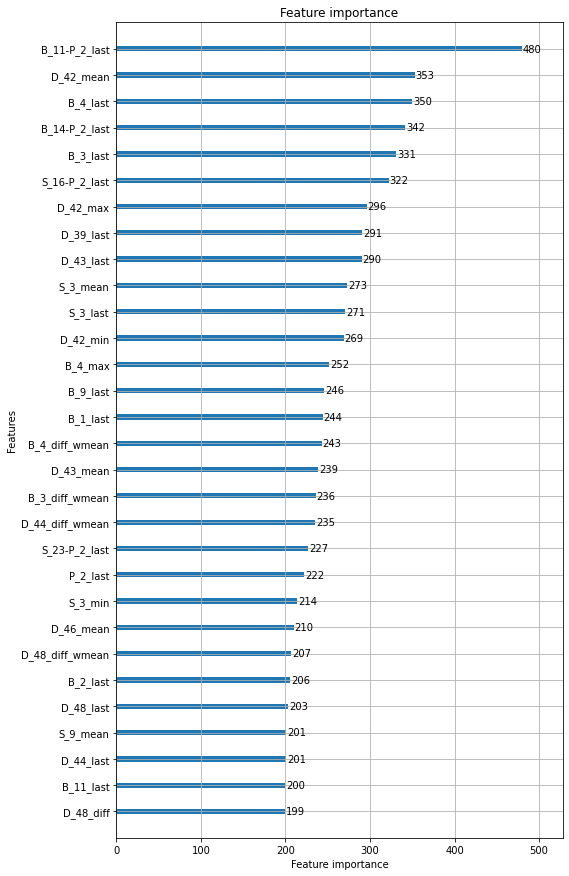

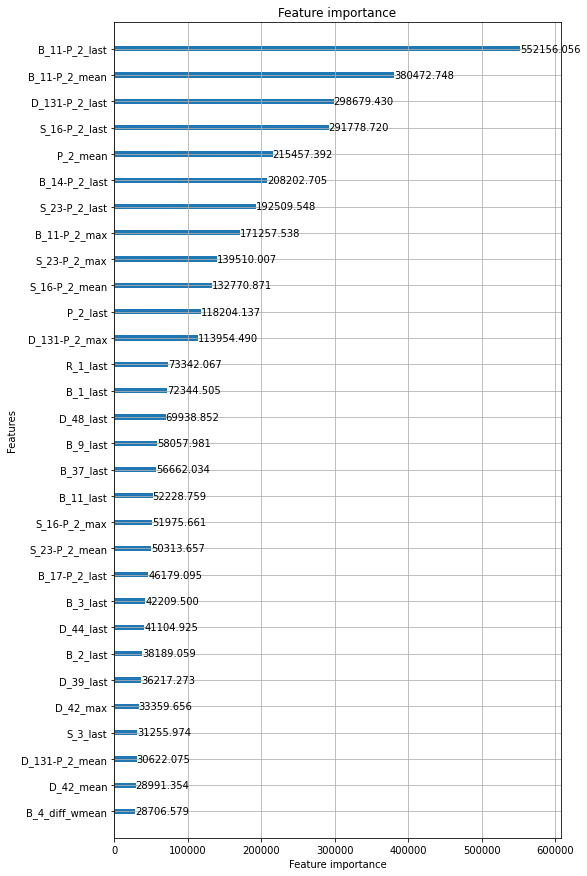

Training time: 53.380329847335815 min.


OOF recall_at4: 0.6682010973844549


OOF normalized_gini: 0.9256236688967284


OOF competition metric: 0.7969123831405917


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.752837	valid_0's recall_at4: 0.604982	valid_0's norm_gini: 0.900693


[100]	valid_0's amex_metric: 0.762604	valid_0's recall_at4: 0.618657	valid_0's norm_gini: 0.906551


[150]	valid_0's amex_metric: 0.769649	valid_0's recall_at4: 0.628924	valid_0's norm_gini: 0.910375


[200]	valid_0's amex_metric: 0.775745	valid_0's recall_at4: 0.637549	valid_0's norm_gini: 0.913941


[250]	valid_0's amex_metric: 0.779848	valid_0's recall_at4: 0.64344	valid_0's norm_gini: 0.916256


[300]	valid_0's amex_metric: 0.7846	valid_0's recall_at4: 0.651309	valid_0's norm_gini: 0.917892


[350]	valid_0's amex_metric: 0.78664	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.919151


[400]	valid_0's amex_metric: 0.788754	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.920183


[450]	valid_0's amex_metric: 0.790273	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.920906


[500]	valid_0's amex_metric: 0.791271	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.921514


[550]	valid_0's amex_metric: 0.792285	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.922028


[600]	valid_0's amex_metric: 0.792472	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.922317


[650]	valid_0's amex_metric: 0.792756	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.922633


[700]	valid_0's amex_metric: 0.793928	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.922956


[750]	valid_0's amex_metric: 0.794298	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.923191


[800]	valid_0's amex_metric: 0.794336	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923394


[850]	valid_0's amex_metric: 0.794941	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.923679


[900]	valid_0's amex_metric: 0.794911	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923871


[950]	valid_0's amex_metric: 0.794931	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924078


[1000]	valid_0's amex_metric: 0.795615	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.92427


[1050]	valid_0's amex_metric: 0.796386	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.924464


[1100]	valid_0's amex_metric: 0.796341	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924668


[1150]	valid_0's amex_metric: 0.796648	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.924778


[1200]	valid_0's amex_metric: 0.796915	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924891


[1250]	valid_0's amex_metric: 0.796931	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.924965


[1300]	valid_0's amex_metric: 0.796848	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.92501


[1350]	valid_0's amex_metric: 0.796928	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.925086


[1400]	valid_0's amex_metric: 0.797732	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925178


[1450]	valid_0's amex_metric: 0.798289	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.92524


[1500]	valid_0's amex_metric: 0.798348	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925317


[1550]	valid_0's amex_metric: 0.798647	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925367


[1600]	valid_0's amex_metric: 0.798683	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.92544


[1650]	valid_0's amex_metric: 0.798508	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.92551


[1700]	valid_0's amex_metric: 0.798484	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925547


[1750]	valid_0's amex_metric: 0.798275	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925591


[1800]	valid_0's amex_metric: 0.798064	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.925633


[1850]	valid_0's amex_metric: 0.797915	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.925671


[1900]	valid_0's amex_metric: 0.797977	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925711


[1950]	valid_0's amex_metric: 0.798056	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925743


[2000]	valid_0's amex_metric: 0.798043	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925758


[2050]	valid_0's amex_metric: 0.797951	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925785


[2100]	valid_0's amex_metric: 0.797899	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925807


[2150]	valid_0's amex_metric: 0.798279	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925852


[2200]	valid_0's amex_metric: 0.798466	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925889


[2250]	valid_0's amex_metric: 0.798108	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.92593


[2300]	valid_0's amex_metric: 0.798141	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925954


[2350]	valid_0's amex_metric: 0.798095	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925989


[2400]	valid_0's amex_metric: 0.798384	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.926019


[2450]	valid_0's amex_metric: 0.798052	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.92607


[2500]	valid_0's amex_metric: 0.798475	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926075


[2550]	valid_0's amex_metric: 0.798963	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.926083


[2600]	valid_0's amex_metric: 0.799023	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.926077


[2650]	valid_0's amex_metric: 0.798953	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926106


[2700]	valid_0's amex_metric: 0.798735	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.926091


[2750]	valid_0's amex_metric: 0.798469	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.926106


[2800]	valid_0's amex_metric: 0.79868	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926107


[2850]	valid_0's amex_metric: 0.798954	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926149


[2900]	valid_0's amex_metric: 0.799048	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.92617


[2950]	valid_0's amex_metric: 0.799305	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926178


[3000]	valid_0's amex_metric: 0.799067	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926207


[3050]	valid_0's amex_metric: 0.799361	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926206


[3100]	valid_0's amex_metric: 0.799333	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926193


[3150]	valid_0's amex_metric: 0.79931	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926189


[3200]	valid_0's amex_metric: 0.799966	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926239


[3250]	valid_0's amex_metric: 0.799684	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926221


[3300]	valid_0's amex_metric: 0.799742	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926211


[3350]	valid_0's amex_metric: 0.799798	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926197


[3400]	valid_0's amex_metric: 0.799445	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926207


[3450]	valid_0's amex_metric: 0.799745	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926217


[3500]	valid_0's amex_metric: 0.799771	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926228


[3550]	valid_0's amex_metric: 0.799458	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926275


[3600]	valid_0's amex_metric: 0.799839	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.92628


[3650]	valid_0's amex_metric: 0.799446	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926292


[3700]	valid_0's amex_metric: 0.79981	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926306


[3750]	valid_0's amex_metric: 0.799773	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926315


[3800]	valid_0's amex_metric: 0.799755	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926322


[3850]	valid_0's amex_metric: 0.799885	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.926329


[3900]	valid_0's amex_metric: 0.800041	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926305


[3950]	valid_0's amex_metric: 0.800405	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.926317


[4000]	valid_0's amex_metric: 0.800443	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926308


[4050]	valid_0's amex_metric: 0.800275	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.92631


[4100]	valid_0's amex_metric: 0.80028	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926319


[4150]	valid_0's amex_metric: 0.800529	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926313


[4200]	valid_0's amex_metric: 0.800831	valid_0's recall_at4: 0.675377	valid_0's norm_gini: 0.926286


[4250]	valid_0's amex_metric: 0.80075	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.926292


[4300]	valid_0's amex_metric: 0.800492	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.92628


[4350]	valid_0's amex_metric: 0.800407	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926279


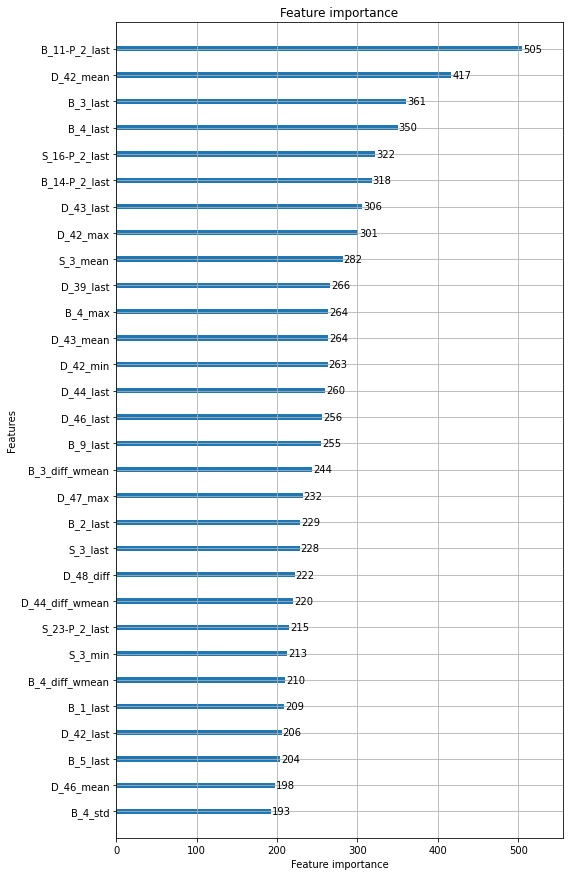

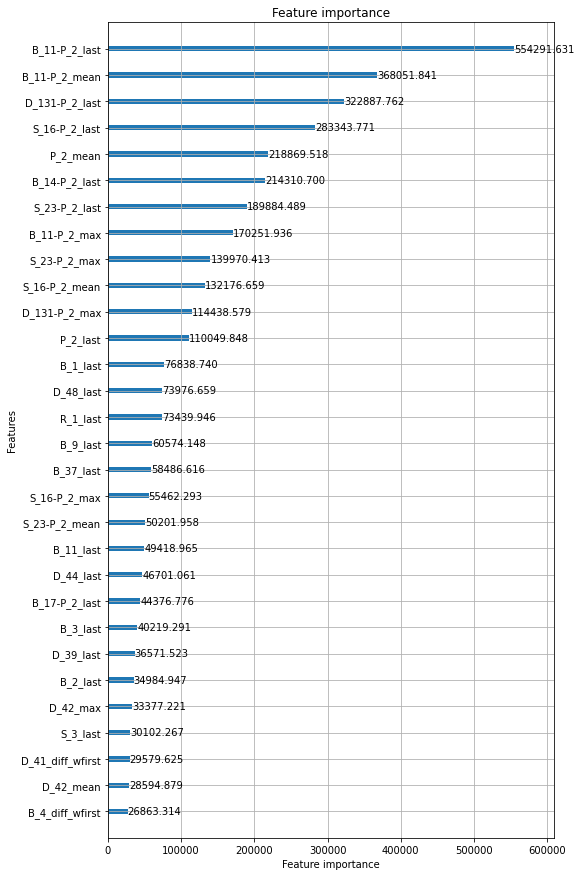

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.749574	valid_0's recall_at4: 0.599554	valid_0's norm_gini: 0.899594


[100]	valid_0's amex_metric: 0.758903	valid_0's recall_at4: 0.612303	valid_0's norm_gini: 0.905502


[150]	valid_0's amex_metric: 0.765209	valid_0's recall_at4: 0.621224	valid_0's norm_gini: 0.909195


[200]	valid_0's amex_metric: 0.770256	valid_0's recall_at4: 0.627788	valid_0's norm_gini: 0.912725


[250]	valid_0's amex_metric: 0.774375	valid_0's recall_at4: 0.633805	valid_0's norm_gini: 0.914945


[300]	valid_0's amex_metric: 0.777966	valid_0's recall_at4: 0.639317	valid_0's norm_gini: 0.916616


[350]	valid_0's amex_metric: 0.780072	valid_0's recall_at4: 0.642304	valid_0's norm_gini: 0.917839


[400]	valid_0's amex_metric: 0.781628	valid_0's recall_at4: 0.64445	valid_0's norm_gini: 0.918806


[450]	valid_0's amex_metric: 0.783006	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.919542


[500]	valid_0's amex_metric: 0.783933	valid_0's recall_at4: 0.647732	valid_0's norm_gini: 0.920134


[550]	valid_0's amex_metric: 0.784992	valid_0's recall_at4: 0.649373	valid_0's norm_gini: 0.920611


[600]	valid_0's amex_metric: 0.785378	valid_0's recall_at4: 0.649794	valid_0's norm_gini: 0.920961


[650]	valid_0's amex_metric: 0.786433	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.921262


[700]	valid_0's amex_metric: 0.786599	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.921595


[750]	valid_0's amex_metric: 0.787515	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921829


[800]	valid_0's amex_metric: 0.787821	valid_0's recall_at4: 0.653623	valid_0's norm_gini: 0.922019


[850]	valid_0's amex_metric: 0.78867	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.922287


[900]	valid_0's amex_metric: 0.788808	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.922437


[950]	valid_0's amex_metric: 0.789055	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.922636


[1000]	valid_0's amex_metric: 0.789763	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.922831


[1050]	valid_0's amex_metric: 0.78999	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.923034


[1100]	valid_0's amex_metric: 0.790516	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923243


[1150]	valid_0's amex_metric: 0.790615	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.9234


[1200]	valid_0's amex_metric: 0.790932	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.923571


[1250]	valid_0's amex_metric: 0.791734	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.92366


[1300]	valid_0's amex_metric: 0.791264	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.923772


[1350]	valid_0's amex_metric: 0.791902	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923827


[1400]	valid_0's amex_metric: 0.791801	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.923879


[1450]	valid_0's amex_metric: 0.792318	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923987


[1500]	valid_0's amex_metric: 0.792746	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924086


[1550]	valid_0's amex_metric: 0.793112	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.924186


[1600]	valid_0's amex_metric: 0.793004	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924221


[1650]	valid_0's amex_metric: 0.793036	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924287


[1700]	valid_0's amex_metric: 0.792846	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.924327


[1750]	valid_0's amex_metric: 0.793187	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924377


[1800]	valid_0's amex_metric: 0.793348	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924406


[1850]	valid_0's amex_metric: 0.793864	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924469


[1900]	valid_0's amex_metric: 0.794272	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.924528


[1950]	valid_0's amex_metric: 0.793906	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924554


[2000]	valid_0's amex_metric: 0.794324	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.92459


[2050]	valid_0's amex_metric: 0.794389	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924637


[2100]	valid_0's amex_metric: 0.794426	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924667


[2150]	valid_0's amex_metric: 0.79392	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924707


[2200]	valid_0's amex_metric: 0.794144	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924734


[2250]	valid_0's amex_metric: 0.794294	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924741


[2300]	valid_0's amex_metric: 0.794606	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924776


[2350]	valid_0's amex_metric: 0.794724	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.9248


[2400]	valid_0's amex_metric: 0.794655	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924831


[2450]	valid_0's amex_metric: 0.794845	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924875


[2500]	valid_0's amex_metric: 0.795071	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.924865


[2550]	valid_0's amex_metric: 0.794723	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924882


[2600]	valid_0's amex_metric: 0.794494	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.924889


[2650]	valid_0's amex_metric: 0.794913	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.924927


[2700]	valid_0's amex_metric: 0.794938	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.924935


[2750]	valid_0's amex_metric: 0.795173	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924942


[2800]	valid_0's amex_metric: 0.794924	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.924948


[2850]	valid_0's amex_metric: 0.794916	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924975


[2900]	valid_0's amex_metric: 0.795463	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.925017


[2950]	valid_0's amex_metric: 0.795345	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.925034


[3000]	valid_0's amex_metric: 0.794981	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.925063


[3050]	valid_0's amex_metric: 0.795279	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.925069


[3100]	valid_0's amex_metric: 0.795494	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.92508


[3150]	valid_0's amex_metric: 0.7954	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.925101


[3200]	valid_0's amex_metric: 0.795476	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925126


[3250]	valid_0's amex_metric: 0.795718	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.925147


[3300]	valid_0's amex_metric: 0.795831	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.925163


[3350]	valid_0's amex_metric: 0.796187	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.92516


[3400]	valid_0's amex_metric: 0.795909	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925151


[3450]	valid_0's amex_metric: 0.795732	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.925176


[3500]	valid_0's amex_metric: 0.796039	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.925202


[3550]	valid_0's amex_metric: 0.796208	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925201


[3600]	valid_0's amex_metric: 0.795585	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.925219


[3650]	valid_0's amex_metric: 0.79597	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.925231


[3700]	valid_0's amex_metric: 0.795684	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925249


[3750]	valid_0's amex_metric: 0.795966	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925265


[3800]	valid_0's amex_metric: 0.795675	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.925273


[3850]	valid_0's amex_metric: 0.795596	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.925284


[3900]	valid_0's amex_metric: 0.795907	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.925274


[3950]	valid_0's amex_metric: 0.795726	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.925291


[4000]	valid_0's amex_metric: 0.795828	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.925283


[4050]	valid_0's amex_metric: 0.795983	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.9253


[4100]	valid_0's amex_metric: 0.795467	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.925318


[4150]	valid_0's amex_metric: 0.795781	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.925317


[4200]	valid_0's amex_metric: 0.795574	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925322


[4250]	valid_0's amex_metric: 0.795877	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925298


[4300]	valid_0's amex_metric: 0.796091	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.925305


[4350]	valid_0's amex_metric: 0.795703	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925287


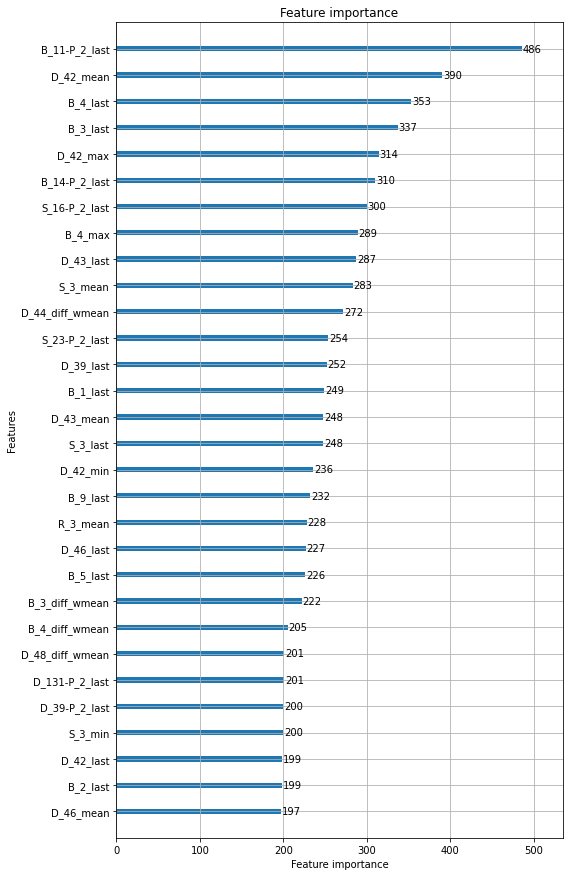

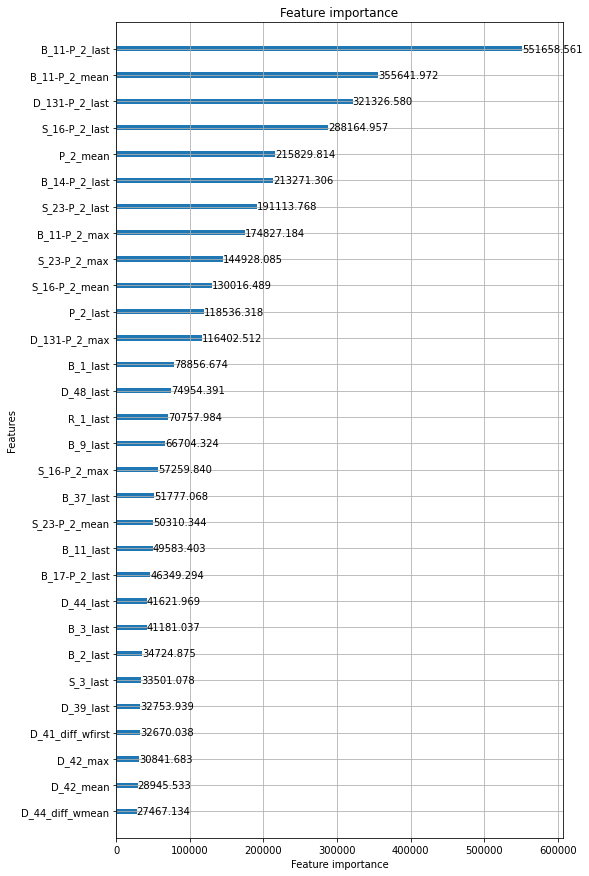

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.74606	valid_0's recall_at4: 0.594379	valid_0's norm_gini: 0.897742


[100]	valid_0's amex_metric: 0.755404	valid_0's recall_at4: 0.607044	valid_0's norm_gini: 0.903765


[150]	valid_0's amex_metric: 0.762272	valid_0's recall_at4: 0.616974	valid_0's norm_gini: 0.907569


[200]	valid_0's amex_metric: 0.767565	valid_0's recall_at4: 0.62379	valid_0's norm_gini: 0.91134


[250]	valid_0's amex_metric: 0.771379	valid_0's recall_at4: 0.628966	valid_0's norm_gini: 0.913793


[300]	valid_0's amex_metric: 0.776155	valid_0's recall_at4: 0.636708	valid_0's norm_gini: 0.915602


[350]	valid_0's amex_metric: 0.778799	valid_0's recall_at4: 0.640663	valid_0's norm_gini: 0.916936


[400]	valid_0's amex_metric: 0.779935	valid_0's recall_at4: 0.641757	valid_0's norm_gini: 0.918112


[450]	valid_0's amex_metric: 0.78159	valid_0's recall_at4: 0.64424	valid_0's norm_gini: 0.91894


[500]	valid_0's amex_metric: 0.782994	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.919519


[550]	valid_0's amex_metric: 0.783606	valid_0's recall_at4: 0.647185	valid_0's norm_gini: 0.920028


[600]	valid_0's amex_metric: 0.785146	valid_0's recall_at4: 0.649878	valid_0's norm_gini: 0.920413


[650]	valid_0's amex_metric: 0.786122	valid_0's recall_at4: 0.651435	valid_0's norm_gini: 0.920809


[700]	valid_0's amex_metric: 0.78617	valid_0's recall_at4: 0.651182	valid_0's norm_gini: 0.921157


[750]	valid_0's amex_metric: 0.787099	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.921417


[800]	valid_0's amex_metric: 0.787338	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.921601


[850]	valid_0's amex_metric: 0.788055	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.921898


[900]	valid_0's amex_metric: 0.788569	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.922084


[950]	valid_0's amex_metric: 0.789144	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.922308


[1000]	valid_0's amex_metric: 0.789312	valid_0's recall_at4: 0.656105	valid_0's norm_gini: 0.922519


[1050]	valid_0's amex_metric: 0.789702	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.922751


[1100]	valid_0's amex_metric: 0.790455	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.922952


[1150]	valid_0's amex_metric: 0.790926	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.923096


[1200]	valid_0's amex_metric: 0.790702	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.923237


[1250]	valid_0's amex_metric: 0.791117	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923351


[1300]	valid_0's amex_metric: 0.791254	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923416


[1350]	valid_0's amex_metric: 0.791488	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923462


[1400]	valid_0's amex_metric: 0.791373	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.923569


[1450]	valid_0's amex_metric: 0.792089	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923654


[1500]	valid_0's amex_metric: 0.792327	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923752


[1550]	valid_0's amex_metric: 0.792031	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.923876


[1600]	valid_0's amex_metric: 0.792845	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.923946


[1650]	valid_0's amex_metric: 0.79311	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924014


[1700]	valid_0's amex_metric: 0.792944	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924061


[1750]	valid_0's amex_metric: 0.793231	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.924129


[1800]	valid_0's amex_metric: 0.793326	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924193


[1850]	valid_0's amex_metric: 0.793122	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924247


[1900]	valid_0's amex_metric: 0.793375	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924291


[1950]	valid_0's amex_metric: 0.792976	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924334


[2000]	valid_0's amex_metric: 0.792849	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924375


[2050]	valid_0's amex_metric: 0.793058	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924414


[2100]	valid_0's amex_metric: 0.793194	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924434


[2150]	valid_0's amex_metric: 0.792767	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.924464


[2200]	valid_0's amex_metric: 0.793127	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924511


[2250]	valid_0's amex_metric: 0.793409	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924527


[2300]	valid_0's amex_metric: 0.793085	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924552


[2350]	valid_0's amex_metric: 0.793595	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924563


[2400]	valid_0's amex_metric: 0.793417	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924586


[2450]	valid_0's amex_metric: 0.793452	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924613


[2500]	valid_0's amex_metric: 0.793557	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924655


[2550]	valid_0's amex_metric: 0.792832	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.924678


[2600]	valid_0's amex_metric: 0.793364	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.92469


[2650]	valid_0's amex_metric: 0.793344	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924692


[2700]	valid_0's amex_metric: 0.793829	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924695


[2750]	valid_0's amex_metric: 0.793441	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.924717


[2800]	valid_0's amex_metric: 0.793569	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.924721


[2850]	valid_0's amex_metric: 0.793541	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.92475


[2900]	valid_0's amex_metric: 0.793237	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924772


[2950]	valid_0's amex_metric: 0.793608	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.9248


[3000]	valid_0's amex_metric: 0.793589	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924804


[3050]	valid_0's amex_metric: 0.793521	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924794


[3100]	valid_0's amex_metric: 0.793411	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.924785


[3150]	valid_0's amex_metric: 0.793733	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924796


[3200]	valid_0's amex_metric: 0.793801	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.924806


[3250]	valid_0's amex_metric: 0.793501	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924795


[3300]	valid_0's amex_metric: 0.793639	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924818


[3350]	valid_0's amex_metric: 0.793889	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924815


[3400]	valid_0's amex_metric: 0.793748	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924826


[3450]	valid_0's amex_metric: 0.793535	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924821


[3500]	valid_0's amex_metric: 0.793413	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924831


[3550]	valid_0's amex_metric: 0.793656	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924852


[3600]	valid_0's amex_metric: 0.792809	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924842


[3650]	valid_0's amex_metric: 0.793529	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924852


[3700]	valid_0's amex_metric: 0.793438	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.924838


[3750]	valid_0's amex_metric: 0.793205	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924834


[3800]	valid_0's amex_metric: 0.793014	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.92483


[3850]	valid_0's amex_metric: 0.792969	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.924825


[3900]	valid_0's amex_metric: 0.793035	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.92483


[3950]	valid_0's amex_metric: 0.793288	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924832


[4000]	valid_0's amex_metric: 0.793331	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924835


[4050]	valid_0's amex_metric: 0.793644	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.92483


[4100]	valid_0's amex_metric: 0.793551	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924811


[4150]	valid_0's amex_metric: 0.793634	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924809


[4200]	valid_0's amex_metric: 0.793579	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.924825


[4250]	valid_0's amex_metric: 0.793602	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924829


[4300]	valid_0's amex_metric: 0.792817	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924859


[4350]	valid_0's amex_metric: 0.792832	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.924846


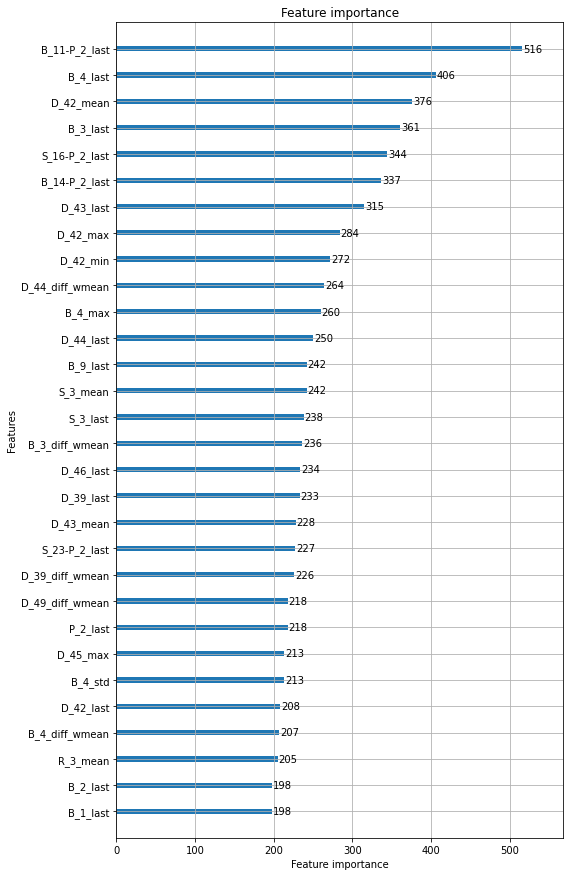

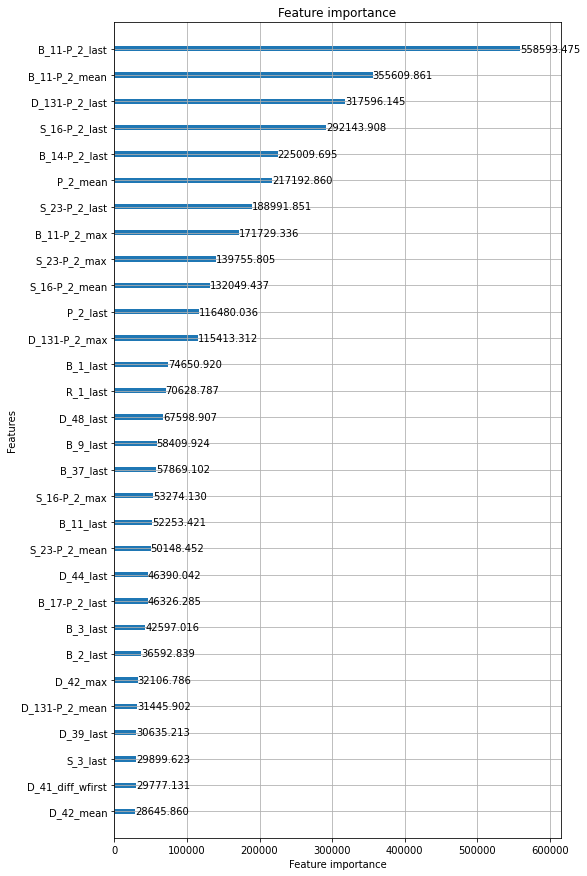

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.752592	valid_0's recall_at4: 0.604587	valid_0's norm_gini: 0.900597


[100]	valid_0's amex_metric: 0.762238	valid_0's recall_at4: 0.61822	valid_0's norm_gini: 0.906256


[150]	valid_0's amex_metric: 0.769517	valid_0's recall_at4: 0.628992	valid_0's norm_gini: 0.910041


[200]	valid_0's amex_metric: 0.775155	valid_0's recall_at4: 0.636735	valid_0's norm_gini: 0.913575


[250]	valid_0's amex_metric: 0.780352	valid_0's recall_at4: 0.64494	valid_0's norm_gini: 0.915763


[300]	valid_0's amex_metric: 0.783323	valid_0's recall_at4: 0.649232	valid_0's norm_gini: 0.917415


[350]	valid_0's amex_metric: 0.78587	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.918636


[400]	valid_0's amex_metric: 0.787752	valid_0's recall_at4: 0.655881	valid_0's norm_gini: 0.919624


[450]	valid_0's amex_metric: 0.788497	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.920314


[500]	valid_0's amex_metric: 0.789994	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.920867


[550]	valid_0's amex_metric: 0.79105	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.921338


[600]	valid_0's amex_metric: 0.791755	valid_0's recall_at4: 0.661814	valid_0's norm_gini: 0.921697


[650]	valid_0's amex_metric: 0.791849	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.922052


[700]	valid_0's amex_metric: 0.791853	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.922355


[750]	valid_0's amex_metric: 0.792563	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.922596


[800]	valid_0's amex_metric: 0.792576	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.922792


[850]	valid_0's amex_metric: 0.793624	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.923036


[900]	valid_0's amex_metric: 0.794544	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.923234


[950]	valid_0's amex_metric: 0.795027	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.923443


[1000]	valid_0's amex_metric: 0.79552	valid_0's recall_at4: 0.66741	valid_0's norm_gini: 0.92363


[1050]	valid_0's amex_metric: 0.795412	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.923834


[1100]	valid_0's amex_metric: 0.79542	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.924061


[1150]	valid_0's amex_metric: 0.795152	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.924198


[1200]	valid_0's amex_metric: 0.795492	valid_0's recall_at4: 0.666653	valid_0's norm_gini: 0.924331


[1250]	valid_0's amex_metric: 0.795748	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.924422


[1300]	valid_0's amex_metric: 0.796209	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.924502


[1350]	valid_0's amex_metric: 0.79579	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.924548


[1400]	valid_0's amex_metric: 0.796069	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924601


[1450]	valid_0's amex_metric: 0.796147	valid_0's recall_at4: 0.66762	valid_0's norm_gini: 0.924673


[1500]	valid_0's amex_metric: 0.795767	valid_0's recall_at4: 0.666821	valid_0's norm_gini: 0.924713


[1550]	valid_0's amex_metric: 0.796067	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.924808


[1600]	valid_0's amex_metric: 0.795847	valid_0's recall_at4: 0.666821	valid_0's norm_gini: 0.924872


[1650]	valid_0's amex_metric: 0.796581	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.92491


[1700]	valid_0's amex_metric: 0.796793	valid_0's recall_at4: 0.66863	valid_0's norm_gini: 0.924957


[1750]	valid_0's amex_metric: 0.797106	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.924993


[1800]	valid_0's amex_metric: 0.797046	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.92504


[1850]	valid_0's amex_metric: 0.796987	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.92509


[1900]	valid_0's amex_metric: 0.796949	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.925142


[1950]	valid_0's amex_metric: 0.79679	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925202


[2000]	valid_0's amex_metric: 0.797207	valid_0's recall_at4: 0.669177	valid_0's norm_gini: 0.925237


[2050]	valid_0's amex_metric: 0.797283	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.925263


[2100]	valid_0's amex_metric: 0.797661	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.925344


[2150]	valid_0's amex_metric: 0.797314	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925408


[2200]	valid_0's amex_metric: 0.797347	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.925433


[2250]	valid_0's amex_metric: 0.797402	valid_0's recall_at4: 0.669346	valid_0's norm_gini: 0.925457


[2300]	valid_0's amex_metric: 0.797802	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925502


[2350]	valid_0's amex_metric: 0.797778	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.925536


[2400]	valid_0's amex_metric: 0.797896	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925563


[2450]	valid_0's amex_metric: 0.797913	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925596


[2500]	valid_0's amex_metric: 0.797946	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.925621


[2550]	valid_0's amex_metric: 0.798383	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.925653


[2600]	valid_0's amex_metric: 0.798744	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.925659


[2650]	valid_0's amex_metric: 0.79866	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.925659


[2700]	valid_0's amex_metric: 0.79887	valid_0's recall_at4: 0.672039	valid_0's norm_gini: 0.925701


[2750]	valid_0's amex_metric: 0.798619	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.925705


[2800]	valid_0's amex_metric: 0.798915	valid_0's recall_at4: 0.672123	valid_0's norm_gini: 0.925707


[2850]	valid_0's amex_metric: 0.798699	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.925738


[2900]	valid_0's amex_metric: 0.798313	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.925766


[2950]	valid_0's amex_metric: 0.798197	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.925785


[3000]	valid_0's amex_metric: 0.798367	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.925789


[3050]	valid_0's amex_metric: 0.798352	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925801


[3100]	valid_0's amex_metric: 0.798479	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.925802


[3150]	valid_0's amex_metric: 0.798735	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.925809


[3200]	valid_0's amex_metric: 0.799142	valid_0's recall_at4: 0.672459	valid_0's norm_gini: 0.925824


[3250]	valid_0's amex_metric: 0.799164	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.925826


[3300]	valid_0's amex_metric: 0.799302	valid_0's recall_at4: 0.672754	valid_0's norm_gini: 0.925849


[3350]	valid_0's amex_metric: 0.798863	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.925855


[3400]	valid_0's amex_metric: 0.799285	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.925859


[3450]	valid_0's amex_metric: 0.799169	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.925837


[3500]	valid_0's amex_metric: 0.799111	valid_0's recall_at4: 0.672375	valid_0's norm_gini: 0.925847


[3550]	valid_0's amex_metric: 0.799221	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925857


[3600]	valid_0's amex_metric: 0.798893	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.925873


[3650]	valid_0's amex_metric: 0.799236	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925885


[3700]	valid_0's amex_metric: 0.799175	valid_0's recall_at4: 0.672459	valid_0's norm_gini: 0.92589


[3750]	valid_0's amex_metric: 0.798881	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.925892


[3800]	valid_0's amex_metric: 0.799015	valid_0's recall_at4: 0.672123	valid_0's norm_gini: 0.925908


[3850]	valid_0's amex_metric: 0.799119	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.925905


[3900]	valid_0's amex_metric: 0.799034	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.925903


[3950]	valid_0's amex_metric: 0.798827	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.92591


[4000]	valid_0's amex_metric: 0.799256	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925926


[4050]	valid_0's amex_metric: 0.799344	valid_0's recall_at4: 0.672754	valid_0's norm_gini: 0.925933


[4100]	valid_0's amex_metric: 0.799417	valid_0's recall_at4: 0.672922	valid_0's norm_gini: 0.925912


[4150]	valid_0's amex_metric: 0.79889	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.92591


[4200]	valid_0's amex_metric: 0.799457	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.925908


[4250]	valid_0's amex_metric: 0.799314	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.925915


[4300]	valid_0's amex_metric: 0.799384	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.92593


[4350]	valid_0's amex_metric: 0.799609	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.925918


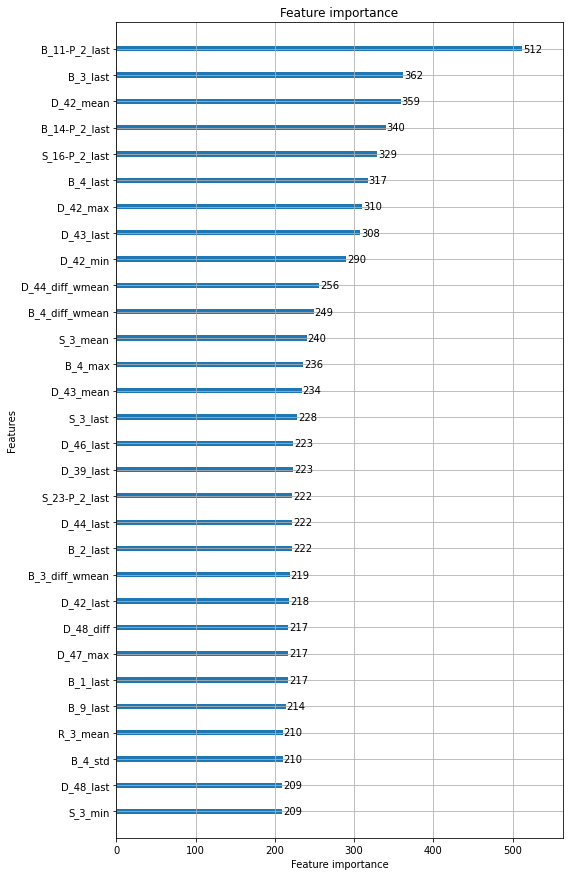

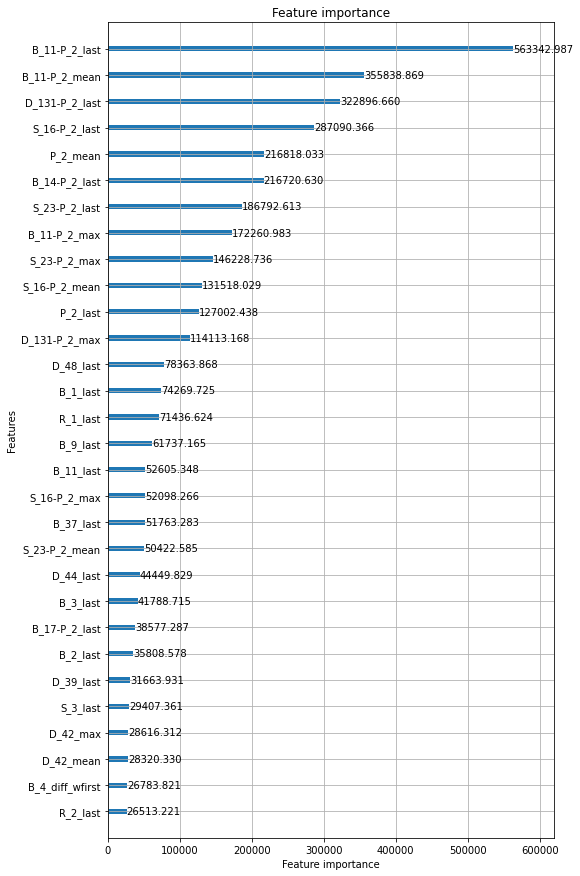

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.752043	valid_0's recall_at4: 0.603408	valid_0's norm_gini: 0.900677


[100]	valid_0's amex_metric: 0.763267	valid_0's recall_at4: 0.619861	valid_0's norm_gini: 0.906673


[150]	valid_0's amex_metric: 0.769622	valid_0's recall_at4: 0.628656	valid_0's norm_gini: 0.910588


[200]	valid_0's amex_metric: 0.775893	valid_0's recall_at4: 0.637745	valid_0's norm_gini: 0.914042


[250]	valid_0's amex_metric: 0.779737	valid_0's recall_at4: 0.643215	valid_0's norm_gini: 0.916259


[300]	valid_0's amex_metric: 0.782449	valid_0's recall_at4: 0.647086	valid_0's norm_gini: 0.917813


[350]	valid_0's amex_metric: 0.784784	valid_0's recall_at4: 0.650494	valid_0's norm_gini: 0.919073


[400]	valid_0's amex_metric: 0.787479	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.920046


[450]	valid_0's amex_metric: 0.789297	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.920693


[500]	valid_0's amex_metric: 0.789368	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.921256


[550]	valid_0's amex_metric: 0.790117	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.921786


[600]	valid_0's amex_metric: 0.790176	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922073


[650]	valid_0's amex_metric: 0.790556	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.922412


[700]	valid_0's amex_metric: 0.791487	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.922717


[750]	valid_0's amex_metric: 0.792469	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.922956


[800]	valid_0's amex_metric: 0.793108	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.92314


[850]	valid_0's amex_metric: 0.793066	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.923393


[900]	valid_0's amex_metric: 0.792944	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.923569


[950]	valid_0's amex_metric: 0.793271	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.923804


[1000]	valid_0's amex_metric: 0.793619	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.923993


[1050]	valid_0's amex_metric: 0.793766	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924204


[1100]	valid_0's amex_metric: 0.793987	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.924392


[1150]	valid_0's amex_metric: 0.794201	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924526


[1200]	valid_0's amex_metric: 0.794486	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924633


[1250]	valid_0's amex_metric: 0.794812	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.924739


[1300]	valid_0's amex_metric: 0.794465	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924802


[1350]	valid_0's amex_metric: 0.7947	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924851


[1400]	valid_0's amex_metric: 0.795011	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.924926


[1450]	valid_0's amex_metric: 0.794643	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.924989


[1500]	valid_0's amex_metric: 0.794924	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.925089


[1550]	valid_0's amex_metric: 0.795181	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.925183


[1600]	valid_0's amex_metric: 0.795849	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.925256


[1650]	valid_0's amex_metric: 0.795782	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925333


[1700]	valid_0's amex_metric: 0.79589	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.92538


[1750]	valid_0's amex_metric: 0.795636	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.925419


[1800]	valid_0's amex_metric: 0.795954	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.925466


[1850]	valid_0's amex_metric: 0.795964	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.925527


[1900]	valid_0's amex_metric: 0.795641	valid_0's recall_at4: 0.665727	valid_0's norm_gini: 0.925555


[1950]	valid_0's amex_metric: 0.795786	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.925592


[2000]	valid_0's amex_metric: 0.796075	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.925623


[2050]	valid_0's amex_metric: 0.796355	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.925678


[2100]	valid_0's amex_metric: 0.796902	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.925721


[2150]	valid_0's amex_metric: 0.796577	valid_0's recall_at4: 0.66741	valid_0's norm_gini: 0.925745


[2200]	valid_0's amex_metric: 0.79667	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.925804


[2250]	valid_0's amex_metric: 0.796684	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.925832


[2300]	valid_0's amex_metric: 0.796823	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.925856


[2350]	valid_0's amex_metric: 0.796764	valid_0's recall_at4: 0.667663	valid_0's norm_gini: 0.925866


[2400]	valid_0's amex_metric: 0.797004	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.925882


[2450]	valid_0's amex_metric: 0.797044	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.92592


[2500]	valid_0's amex_metric: 0.796954	valid_0's recall_at4: 0.667957	valid_0's norm_gini: 0.92595


[2550]	valid_0's amex_metric: 0.797214	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925966


[2600]	valid_0's amex_metric: 0.79664	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925954


[2650]	valid_0's amex_metric: 0.796713	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.925974


[2700]	valid_0's amex_metric: 0.797157	valid_0's recall_at4: 0.668336	valid_0's norm_gini: 0.925979


[2750]	valid_0's amex_metric: 0.796631	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.925978


[2800]	valid_0's amex_metric: 0.796806	valid_0's recall_at4: 0.66762	valid_0's norm_gini: 0.925991


[2850]	valid_0's amex_metric: 0.796871	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925996


[2900]	valid_0's amex_metric: 0.797198	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.926018


[2950]	valid_0's amex_metric: 0.797212	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.926045


[3000]	valid_0's amex_metric: 0.797249	valid_0's recall_at4: 0.66842	valid_0's norm_gini: 0.926078


[3050]	valid_0's amex_metric: 0.797417	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.92612


[3100]	valid_0's amex_metric: 0.797187	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.926123


[3150]	valid_0's amex_metric: 0.797489	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.926137


[3200]	valid_0's amex_metric: 0.797678	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.926136


[3250]	valid_0's amex_metric: 0.797893	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.926146


[3300]	valid_0's amex_metric: 0.798423	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.926154


[3350]	valid_0's amex_metric: 0.798217	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.926163


[3400]	valid_0's amex_metric: 0.798064	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.926152


[3450]	valid_0's amex_metric: 0.797823	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.926174


[3500]	valid_0's amex_metric: 0.797914	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.926188


[3550]	valid_0's amex_metric: 0.797702	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.926184


[3600]	valid_0's amex_metric: 0.797379	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.926211


[3650]	valid_0's amex_metric: 0.797304	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.92623


[3700]	valid_0's amex_metric: 0.797646	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.926242


[3750]	valid_0's amex_metric: 0.797266	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.926239


[3800]	valid_0's amex_metric: 0.797579	valid_0's recall_at4: 0.668925	valid_0's norm_gini: 0.926234


[3850]	valid_0's amex_metric: 0.797492	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.926228


[3900]	valid_0's amex_metric: 0.797285	valid_0's recall_at4: 0.668336	valid_0's norm_gini: 0.926235


[3950]	valid_0's amex_metric: 0.797723	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.926227


[4000]	valid_0's amex_metric: 0.79783	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.92623


[4050]	valid_0's amex_metric: 0.797619	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.926229


[4100]	valid_0's amex_metric: 0.797113	valid_0's recall_at4: 0.667999	valid_0's norm_gini: 0.926227


[4150]	valid_0's amex_metric: 0.79698	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.926212


[4200]	valid_0's amex_metric: 0.797194	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.92622


[4250]	valid_0's amex_metric: 0.797621	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.926233


[4300]	valid_0's amex_metric: 0.797511	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.926223


[4350]	valid_0's amex_metric: 0.797973	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.926221


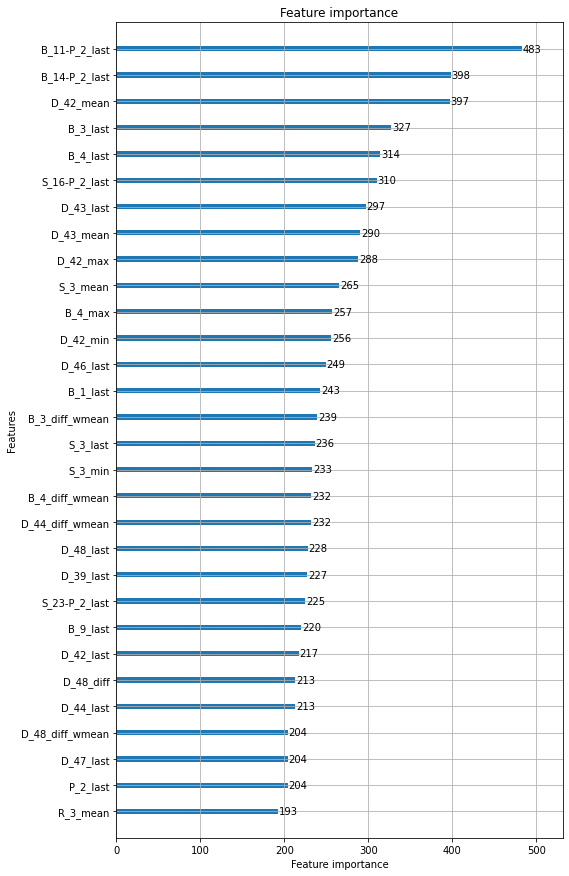

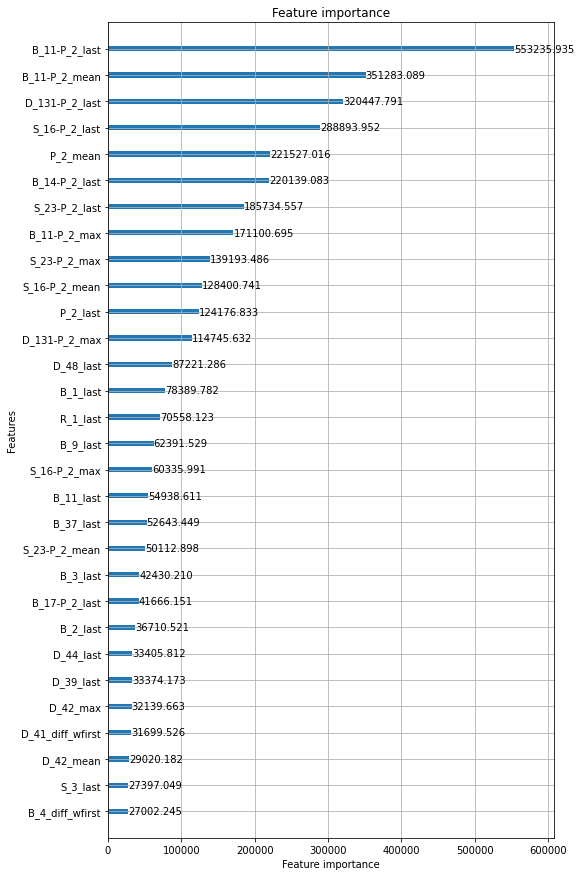

Training time: 52.75270583629608 min.
OOF recall_at4: 0.6690847275053018
OOF normalized_gini: 0.9255739715202059
OOF competition metric: 0.7973293495127538


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


[50]	valid_0's amex_metric: 0.748369	valid_0's recall_at4: 0.598165	valid_0's norm_gini: 0.898572


[100]	valid_0's amex_metric: 0.757961	valid_0's recall_at4: 0.611546	valid_0's norm_gini: 0.904377


[150]	valid_0's amex_metric: 0.763741	valid_0's recall_at4: 0.61912	valid_0's norm_gini: 0.908363


[200]	valid_0's amex_metric: 0.769836	valid_0's recall_at4: 0.627619	valid_0's norm_gini: 0.912052


[250]	valid_0's amex_metric: 0.774526	valid_0's recall_at4: 0.63473	valid_0's norm_gini: 0.914322


[300]	valid_0's amex_metric: 0.776594	valid_0's recall_at4: 0.637255	valid_0's norm_gini: 0.915933


[350]	valid_0's amex_metric: 0.780146	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.917188


[400]	valid_0's amex_metric: 0.78253	valid_0's recall_at4: 0.646933	valid_0's norm_gini: 0.918128


[450]	valid_0's amex_metric: 0.784265	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.918821


[500]	valid_0's amex_metric: 0.785997	valid_0's recall_at4: 0.652613	valid_0's norm_gini: 0.919381


[550]	valid_0's amex_metric: 0.78598	valid_0's recall_at4: 0.65215	valid_0's norm_gini: 0.919809


[600]	valid_0's amex_metric: 0.786154	valid_0's recall_at4: 0.652192	valid_0's norm_gini: 0.920116


[650]	valid_0's amex_metric: 0.787044	valid_0's recall_at4: 0.653665	valid_0's norm_gini: 0.920422


[700]	valid_0's amex_metric: 0.787411	valid_0's recall_at4: 0.654086	valid_0's norm_gini: 0.920736


[750]	valid_0's amex_metric: 0.787693	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.920963


[800]	valid_0's amex_metric: 0.788266	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.921142


[850]	valid_0's amex_metric: 0.788776	valid_0's recall_at4: 0.65619	valid_0's norm_gini: 0.921363


[900]	valid_0's amex_metric: 0.788974	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.921548


[950]	valid_0's amex_metric: 0.788851	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.921765


[1000]	valid_0's amex_metric: 0.790018	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.921953


[1050]	valid_0's amex_metric: 0.789775	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922141


[1100]	valid_0's amex_metric: 0.790779	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.92234


[1150]	valid_0's amex_metric: 0.79121	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922486


[1200]	valid_0's amex_metric: 0.791386	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.922586


[1250]	valid_0's amex_metric: 0.791314	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922695


[1300]	valid_0's amex_metric: 0.79172	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.922749


[1350]	valid_0's amex_metric: 0.791783	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922791


[1400]	valid_0's amex_metric: 0.792347	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.922908


[1450]	valid_0's amex_metric: 0.79207	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.922986


[1500]	valid_0's amex_metric: 0.792299	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.923066


[1550]	valid_0's amex_metric: 0.792569	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.923142


[1600]	valid_0's amex_metric: 0.792528	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.923228


[1650]	valid_0's amex_metric: 0.792771	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923294


[1700]	valid_0's amex_metric: 0.792984	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.92334


[1750]	valid_0's amex_metric: 0.793736	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.923415


[1800]	valid_0's amex_metric: 0.793826	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923468


[1850]	valid_0's amex_metric: 0.793682	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.923516


[1900]	valid_0's amex_metric: 0.793308	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923567


[1950]	valid_0's amex_metric: 0.793273	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.923625


[2000]	valid_0's amex_metric: 0.793817	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.92366


[2050]	valid_0's amex_metric: 0.794233	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923693


[2100]	valid_0's amex_metric: 0.794008	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.923748


[2150]	valid_0's amex_metric: 0.793997	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.92381


[2200]	valid_0's amex_metric: 0.793999	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923856


[2250]	valid_0's amex_metric: 0.794014	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923885


[2300]	valid_0's amex_metric: 0.794027	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923913


[2350]	valid_0's amex_metric: 0.793623	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923946


[2400]	valid_0's amex_metric: 0.793653	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.923963


[2450]	valid_0's amex_metric: 0.793889	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924015


[2500]	valid_0's amex_metric: 0.793872	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924022


[2550]	valid_0's amex_metric: 0.793883	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924046


[2600]	valid_0's amex_metric: 0.793382	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924053


[2650]	valid_0's amex_metric: 0.793325	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.924066


[2700]	valid_0's amex_metric: 0.793392	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924072


[2750]	valid_0's amex_metric: 0.793273	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924087


[2800]	valid_0's amex_metric: 0.794071	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.924084


[2850]	valid_0's amex_metric: 0.794274	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924111


[2900]	valid_0's amex_metric: 0.794249	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924103


[2950]	valid_0's amex_metric: 0.794042	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.92411


[3000]	valid_0's amex_metric: 0.793883	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924128


[3050]	valid_0's amex_metric: 0.793798	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924127


[3100]	valid_0's amex_metric: 0.794093	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.924127


[3150]	valid_0's amex_metric: 0.793937	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924153


[3200]	valid_0's amex_metric: 0.794447	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.924162


[3250]	valid_0's amex_metric: 0.794306	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924175


[3300]	valid_0's amex_metric: 0.794072	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924171


[3350]	valid_0's amex_metric: 0.794365	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924167


[3400]	valid_0's amex_metric: 0.79459	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.924154


[3450]	valid_0's amex_metric: 0.794275	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924156


[3500]	valid_0's amex_metric: 0.794424	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924159


[3550]	valid_0's amex_metric: 0.794764	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924165


[3600]	valid_0's amex_metric: 0.795418	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924169


[3650]	valid_0's amex_metric: 0.79508	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924167


[3700]	valid_0's amex_metric: 0.795004	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924183


[3750]	valid_0's amex_metric: 0.795196	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924187


[3800]	valid_0's amex_metric: 0.79514	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.924202


[3850]	valid_0's amex_metric: 0.795334	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924212


[3900]	valid_0's amex_metric: 0.795062	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924214


[3950]	valid_0's amex_metric: 0.795089	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.924226


[4000]	valid_0's amex_metric: 0.795089	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.924227


[4050]	valid_0's amex_metric: 0.794996	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924209


[4100]	valid_0's amex_metric: 0.794595	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924207


[4150]	valid_0's amex_metric: 0.795095	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.924238


[4200]	valid_0's amex_metric: 0.794792	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924222


[4250]	valid_0's amex_metric: 0.794983	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924225


[4300]	valid_0's amex_metric: 0.795029	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924234


[4350]	valid_0's amex_metric: 0.795195	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.924229


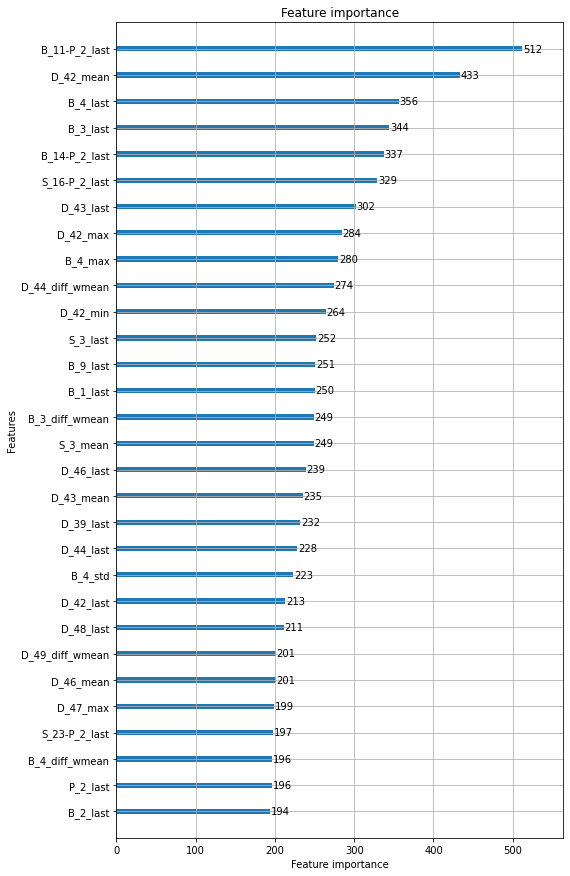

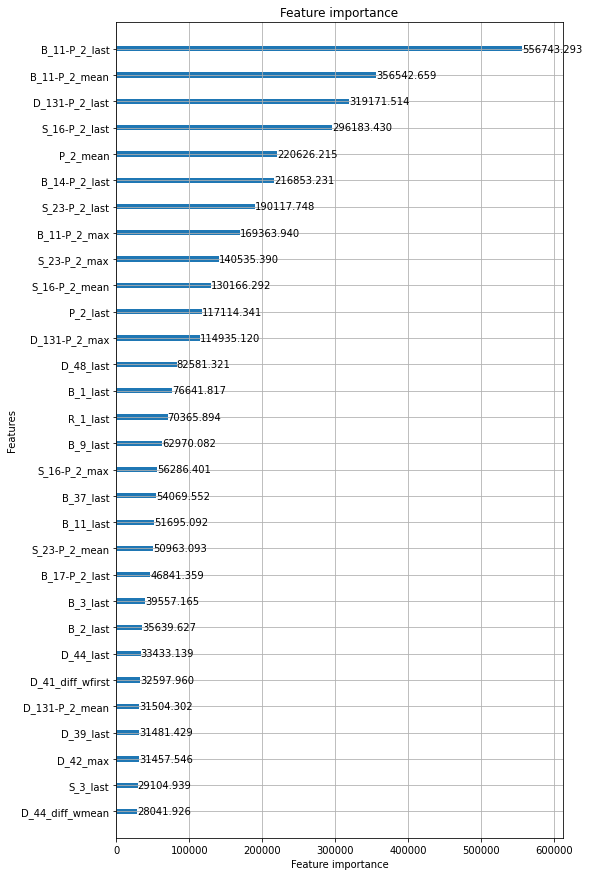

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.747466	valid_0's recall_at4: 0.594841	valid_0's norm_gini: 0.90009


[100]	valid_0's amex_metric: 0.757791	valid_0's recall_at4: 0.609484	valid_0's norm_gini: 0.906098


[150]	valid_0's amex_metric: 0.763541	valid_0's recall_at4: 0.61731	valid_0's norm_gini: 0.909771


[200]	valid_0's amex_metric: 0.770309	valid_0's recall_at4: 0.627409	valid_0's norm_gini: 0.91321


[250]	valid_0's amex_metric: 0.772328	valid_0's recall_at4: 0.629387	valid_0's norm_gini: 0.91527


[300]	valid_0's amex_metric: 0.776783	valid_0's recall_at4: 0.636582	valid_0's norm_gini: 0.916984


[350]	valid_0's amex_metric: 0.778135	valid_0's recall_at4: 0.638054	valid_0's norm_gini: 0.918216


[400]	valid_0's amex_metric: 0.780432	valid_0's recall_at4: 0.641631	valid_0's norm_gini: 0.919232


[450]	valid_0's amex_metric: 0.781128	valid_0's recall_at4: 0.642304	valid_0's norm_gini: 0.919952


[500]	valid_0's amex_metric: 0.782279	valid_0's recall_at4: 0.644071	valid_0's norm_gini: 0.920487


[550]	valid_0's amex_metric: 0.782441	valid_0's recall_at4: 0.643945	valid_0's norm_gini: 0.920938


[600]	valid_0's amex_metric: 0.783649	valid_0's recall_at4: 0.646049	valid_0's norm_gini: 0.921249


[650]	valid_0's amex_metric: 0.784873	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.921593


[700]	valid_0's amex_metric: 0.785423	valid_0's recall_at4: 0.648952	valid_0's norm_gini: 0.921894


[750]	valid_0's amex_metric: 0.785675	valid_0's recall_at4: 0.649205	valid_0's norm_gini: 0.922145


[800]	valid_0's amex_metric: 0.786144	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.922369


[850]	valid_0's amex_metric: 0.786948	valid_0's recall_at4: 0.651267	valid_0's norm_gini: 0.92263


[900]	valid_0's amex_metric: 0.787569	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.922777


[950]	valid_0's amex_metric: 0.788279	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.922977


[1000]	valid_0's amex_metric: 0.788524	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.923172


[1050]	valid_0's amex_metric: 0.789035	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.923396


[1100]	valid_0's amex_metric: 0.788854	valid_0's recall_at4: 0.654086	valid_0's norm_gini: 0.923622


[1150]	valid_0's amex_metric: 0.789203	valid_0's recall_at4: 0.654633	valid_0's norm_gini: 0.923772


[1200]	valid_0's amex_metric: 0.7893	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.923926


[1250]	valid_0's amex_metric: 0.789622	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.924021


[1300]	valid_0's amex_metric: 0.789806	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.924095


[1350]	valid_0's amex_metric: 0.790036	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.924178


[1400]	valid_0's amex_metric: 0.790004	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.924281


[1450]	valid_0's amex_metric: 0.789832	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.924359


[1500]	valid_0's amex_metric: 0.790405	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.924452


[1550]	valid_0's amex_metric: 0.790689	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.924557


[1600]	valid_0's amex_metric: 0.790691	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.924604


[1650]	valid_0's amex_metric: 0.79106	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.924667


[1700]	valid_0's amex_metric: 0.791845	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.924724


[1750]	valid_0's amex_metric: 0.791742	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.924769


[1800]	valid_0's amex_metric: 0.791934	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.924859


[1850]	valid_0's amex_metric: 0.7921	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.924896


[1900]	valid_0's amex_metric: 0.792022	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.924951


[1950]	valid_0's amex_metric: 0.792545	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.924987


[2000]	valid_0's amex_metric: 0.792595	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.925044


[2050]	valid_0's amex_metric: 0.792774	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.925109


[2100]	valid_0's amex_metric: 0.792541	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.925147


[2150]	valid_0's amex_metric: 0.792118	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.925186


[2200]	valid_0's amex_metric: 0.792364	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.925215


[2250]	valid_0's amex_metric: 0.792163	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.925232


[2300]	valid_0's amex_metric: 0.792004	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.925253


[2350]	valid_0's amex_metric: 0.792342	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.925297


[2400]	valid_0's amex_metric: 0.792368	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.925307


[2450]	valid_0's amex_metric: 0.792848	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.925341


[2500]	valid_0's amex_metric: 0.79246	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.925364


[2550]	valid_0's amex_metric: 0.79258	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.925395


[2600]	valid_0's amex_metric: 0.792479	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.925403


[2650]	valid_0's amex_metric: 0.792801	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.925416


[2700]	valid_0's amex_metric: 0.7924	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.925413


[2750]	valid_0's amex_metric: 0.792367	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.925431


[2800]	valid_0's amex_metric: 0.792486	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.925458


[2850]	valid_0's amex_metric: 0.792101	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.925446


[2900]	valid_0's amex_metric: 0.792694	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.925454


[2950]	valid_0's amex_metric: 0.792279	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.925465


[3000]	valid_0's amex_metric: 0.792442	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.925497


[3050]	valid_0's amex_metric: 0.792401	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.925498


[3100]	valid_0's amex_metric: 0.792222	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.925519


[3150]	valid_0's amex_metric: 0.791747	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.925537


[3200]	valid_0's amex_metric: 0.791674	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.92556


[3250]	valid_0's amex_metric: 0.791906	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.925561


[3300]	valid_0's amex_metric: 0.791533	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.925573


[3350]	valid_0's amex_metric: 0.792008	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.925555


[3400]	valid_0's amex_metric: 0.791444	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.925563


[3450]	valid_0's amex_metric: 0.791496	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.925582


[3500]	valid_0's amex_metric: 0.791416	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.925591


[3550]	valid_0's amex_metric: 0.791593	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.925607


[3600]	valid_0's amex_metric: 0.79162	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.92562


[3650]	valid_0's amex_metric: 0.791165	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.925636


[3700]	valid_0's amex_metric: 0.791414	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.92567


[3750]	valid_0's amex_metric: 0.791603	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.925671


[3800]	valid_0's amex_metric: 0.792026	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.925674


[3850]	valid_0's amex_metric: 0.791783	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.925693


[3900]	valid_0's amex_metric: 0.791937	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.925708


[3950]	valid_0's amex_metric: 0.791695	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.925729


[4000]	valid_0's amex_metric: 0.792176	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.925722


[4050]	valid_0's amex_metric: 0.792034	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.925733


[4100]	valid_0's amex_metric: 0.791952	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.925737


[4150]	valid_0's amex_metric: 0.79206	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.925743


[4200]	valid_0's amex_metric: 0.792031	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.925726


[4250]	valid_0's amex_metric: 0.791755	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.925721


[4300]	valid_0's amex_metric: 0.792199	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.925727


[4350]	valid_0's amex_metric: 0.791861	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.925724


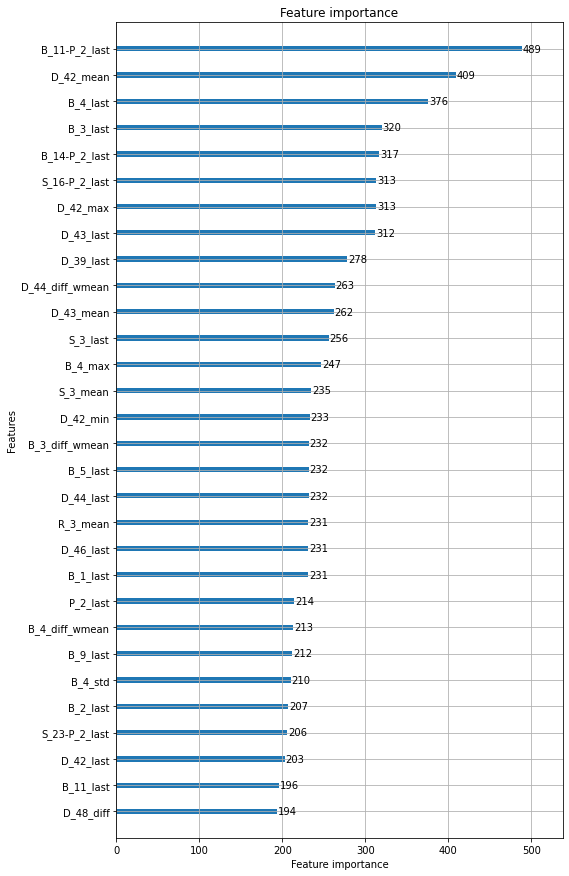

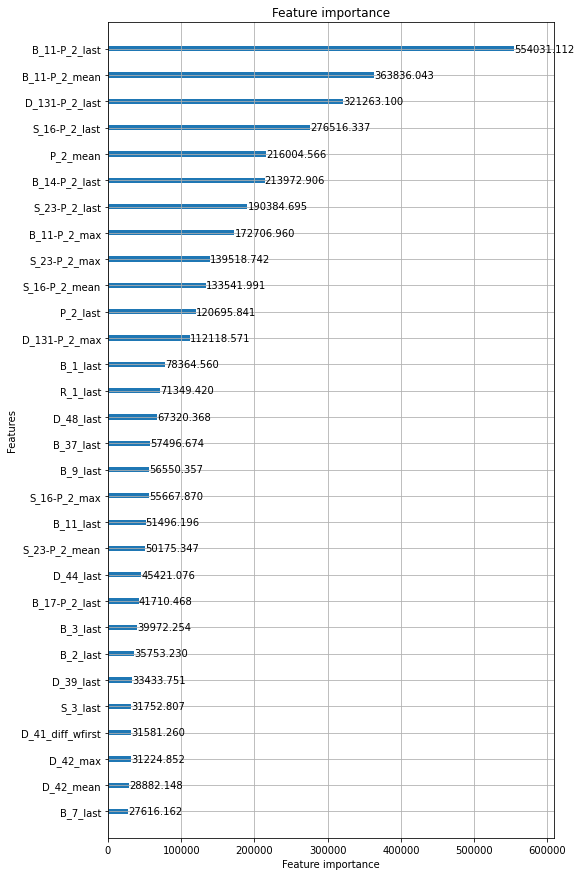

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.749704	valid_0's recall_at4: 0.600858	valid_0's norm_gini: 0.898549


[100]	valid_0's amex_metric: 0.761838	valid_0's recall_at4: 0.618994	valid_0's norm_gini: 0.904683


[150]	valid_0's amex_metric: 0.769204	valid_0's recall_at4: 0.629471	valid_0's norm_gini: 0.908938


[200]	valid_0's amex_metric: 0.774746	valid_0's recall_at4: 0.636834	valid_0's norm_gini: 0.912658


[250]	valid_0's amex_metric: 0.778071	valid_0's recall_at4: 0.641084	valid_0's norm_gini: 0.915058


[300]	valid_0's amex_metric: 0.781031	valid_0's recall_at4: 0.645292	valid_0's norm_gini: 0.916771


[350]	valid_0's amex_metric: 0.783647	valid_0's recall_at4: 0.649163	valid_0's norm_gini: 0.918132


[400]	valid_0's amex_metric: 0.785745	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.919214


[450]	valid_0's amex_metric: 0.787541	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.920028


[500]	valid_0's amex_metric: 0.789153	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.920643


[550]	valid_0's amex_metric: 0.790342	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.921128


[600]	valid_0's amex_metric: 0.791246	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.921463


[650]	valid_0's amex_metric: 0.791985	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.921848


[700]	valid_0's amex_metric: 0.792757	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.922171


[750]	valid_0's amex_metric: 0.792892	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.922399


[800]	valid_0's amex_metric: 0.793507	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.922578


[850]	valid_0's amex_metric: 0.794554	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.922904


[900]	valid_0's amex_metric: 0.794255	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.923064


[950]	valid_0's amex_metric: 0.795242	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.923313


[1000]	valid_0's amex_metric: 0.796368	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.923544


[1050]	valid_0's amex_metric: 0.796272	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.923774


[1100]	valid_0's amex_metric: 0.796898	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.924015


[1150]	valid_0's amex_metric: 0.797348	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.924159


[1200]	valid_0's amex_metric: 0.797686	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.924287


[1250]	valid_0's amex_metric: 0.797889	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.924398


[1300]	valid_0's amex_metric: 0.797317	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.924475


[1350]	valid_0's amex_metric: 0.797476	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.924541


[1400]	valid_0's amex_metric: 0.79763	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.924597


[1450]	valid_0's amex_metric: 0.797776	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.924679


[1500]	valid_0's amex_metric: 0.797993	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.924775


[1550]	valid_0's amex_metric: 0.798276	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.924878


[1600]	valid_0's amex_metric: 0.798072	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.924933


[1650]	valid_0's amex_metric: 0.798327	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925022


[1700]	valid_0's amex_metric: 0.798333	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925076


[1750]	valid_0's amex_metric: 0.798755	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925122


[1800]	valid_0's amex_metric: 0.798769	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.92515


[1850]	valid_0's amex_metric: 0.798863	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.92521


[1900]	valid_0's amex_metric: 0.7989	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925242


[1950]	valid_0's amex_metric: 0.799345	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925292


[2000]	valid_0's amex_metric: 0.799385	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.92533


[2050]	valid_0's amex_metric: 0.800023	valid_0's recall_at4: 0.674661	valid_0's norm_gini: 0.925385


[2100]	valid_0's amex_metric: 0.799798	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.92544


[2150]	valid_0's amex_metric: 0.799787	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.925502


[2200]	valid_0's amex_metric: 0.79947	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925542


[2250]	valid_0's amex_metric: 0.799899	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.925558


[2300]	valid_0's amex_metric: 0.800011	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.92557


[2350]	valid_0's amex_metric: 0.799916	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.925591


[2400]	valid_0's amex_metric: 0.799876	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.925637


[2450]	valid_0's amex_metric: 0.799951	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.925662


[2500]	valid_0's amex_metric: 0.799984	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.925685


[2550]	valid_0's amex_metric: 0.80001	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.925696


[2600]	valid_0's amex_metric: 0.800323	valid_0's recall_at4: 0.674956	valid_0's norm_gini: 0.92569


[2650]	valid_0's amex_metric: 0.800065	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.925721


[2700]	valid_0's amex_metric: 0.799751	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.925725


[2750]	valid_0's amex_metric: 0.80012	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.925748


[2800]	valid_0's amex_metric: 0.799484	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.925737


[2850]	valid_0's amex_metric: 0.79952	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925766


[2900]	valid_0's amex_metric: 0.799191	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.925783


[2950]	valid_0's amex_metric: 0.799577	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.925796


[3000]	valid_0's amex_metric: 0.79958	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.925802


[3050]	valid_0's amex_metric: 0.79927	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.925814


[3100]	valid_0's amex_metric: 0.799374	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925812


[3150]	valid_0's amex_metric: 0.7993	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.925831


[3200]	valid_0's amex_metric: 0.798915	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925862


[3250]	valid_0's amex_metric: 0.799026	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925873


[3300]	valid_0's amex_metric: 0.799214	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92587


[3350]	valid_0's amex_metric: 0.799365	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925877


[3400]	valid_0's amex_metric: 0.799036	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925893


[3450]	valid_0's amex_metric: 0.798955	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.9259


[3500]	valid_0's amex_metric: 0.799279	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.925917


[3550]	valid_0's amex_metric: 0.799708	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.925934


[3600]	valid_0's amex_metric: 0.799475	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.925972


[3650]	valid_0's amex_metric: 0.799462	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925988


[3700]	valid_0's amex_metric: 0.799637	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926002


[3750]	valid_0's amex_metric: 0.799719	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.925997


[3800]	valid_0's amex_metric: 0.799181	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926015


[3850]	valid_0's amex_metric: 0.799477	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.926019


[3900]	valid_0's amex_metric: 0.798845	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.926016


[3950]	valid_0's amex_metric: 0.798255	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.926014


[4000]	valid_0's amex_metric: 0.798579	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926031


[4050]	valid_0's amex_metric: 0.79893	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.926017


[4100]	valid_0's amex_metric: 0.798863	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926011


[4150]	valid_0's amex_metric: 0.798951	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926018


[4200]	valid_0's amex_metric: 0.79883	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.926028


[4250]	valid_0's amex_metric: 0.79899	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.926012


[4300]	valid_0's amex_metric: 0.799734	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.926028


[4350]	valid_0's amex_metric: 0.799841	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.92603


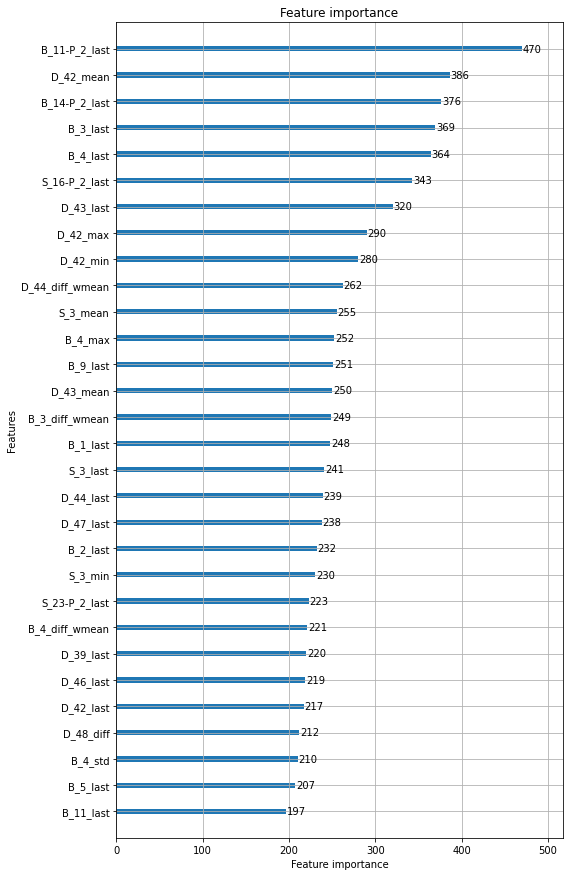

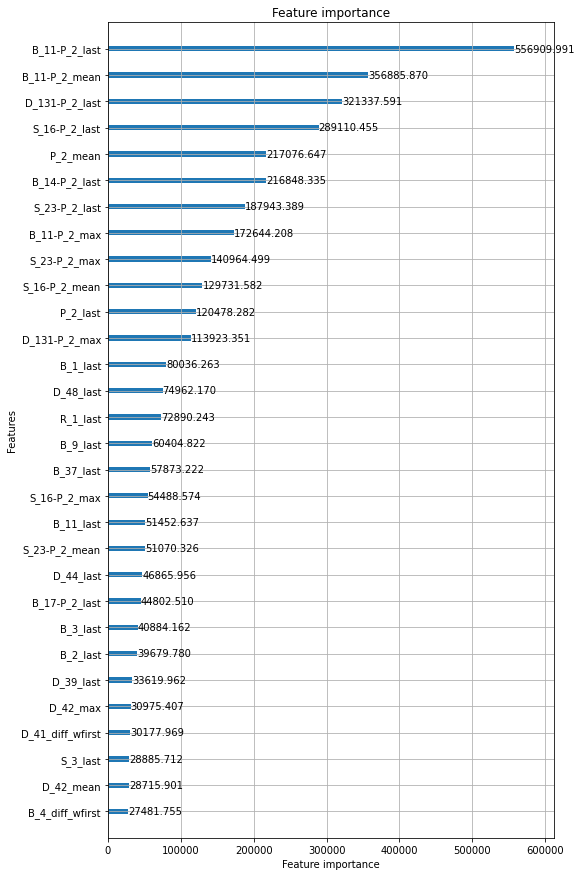

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.754672	valid_0's recall_at4: 0.606312	valid_0's norm_gini: 0.903033


[100]	valid_0's amex_metric: 0.765431	valid_0's recall_at4: 0.622007	valid_0's norm_gini: 0.908855


[150]	valid_0's amex_metric: 0.772391	valid_0's recall_at4: 0.632316	valid_0's norm_gini: 0.912465


[200]	valid_0's amex_metric: 0.778443	valid_0's recall_at4: 0.640816	valid_0's norm_gini: 0.91607


[250]	valid_0's amex_metric: 0.783709	valid_0's recall_at4: 0.64898	valid_0's norm_gini: 0.918439


[300]	valid_0's amex_metric: 0.787723	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.920113


[350]	valid_0's amex_metric: 0.789396	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.921228


[400]	valid_0's amex_metric: 0.791181	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.922231


[450]	valid_0's amex_metric: 0.792098	valid_0's recall_at4: 0.661224	valid_0's norm_gini: 0.922972


[500]	valid_0's amex_metric: 0.792921	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.923524


[550]	valid_0's amex_metric: 0.793773	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.924007


[600]	valid_0's amex_metric: 0.794284	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924313


[650]	valid_0's amex_metric: 0.794708	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.924657


[700]	valid_0's amex_metric: 0.795416	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.924936


[750]	valid_0's amex_metric: 0.79619	valid_0's recall_at4: 0.6672	valid_0's norm_gini: 0.925179


[800]	valid_0's amex_metric: 0.796848	valid_0's recall_at4: 0.668336	valid_0's norm_gini: 0.925359


[850]	valid_0's amex_metric: 0.798219	valid_0's recall_at4: 0.670818	valid_0's norm_gini: 0.925619


[900]	valid_0's amex_metric: 0.798358	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925814


[950]	valid_0's amex_metric: 0.798508	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.926029


[1000]	valid_0's amex_metric: 0.798564	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.926268


[1050]	valid_0's amex_metric: 0.79953	valid_0's recall_at4: 0.672544	valid_0's norm_gini: 0.926517


[1100]	valid_0's amex_metric: 0.800393	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926728


[1150]	valid_0's amex_metric: 0.801247	valid_0's recall_at4: 0.675615	valid_0's norm_gini: 0.926878


[1200]	valid_0's amex_metric: 0.801164	valid_0's recall_at4: 0.675321	valid_0's norm_gini: 0.927007


[1250]	valid_0's amex_metric: 0.801688	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.927088


[1300]	valid_0's amex_metric: 0.801555	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927159


[1350]	valid_0's amex_metric: 0.801873	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927205


[1400]	valid_0's amex_metric: 0.801936	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.92729


[1450]	valid_0's amex_metric: 0.802586	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.927368


[1500]	valid_0's amex_metric: 0.802525	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.927457


[1550]	valid_0's amex_metric: 0.802423	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.927548


[1600]	valid_0's amex_metric: 0.80234	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.927634


[1650]	valid_0's amex_metric: 0.802251	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927709


[1700]	valid_0's amex_metric: 0.802327	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.927734


[1750]	valid_0's amex_metric: 0.801806	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.927786


[1800]	valid_0's amex_metric: 0.801857	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.927847


[1850]	valid_0's amex_metric: 0.802147	valid_0's recall_at4: 0.676415	valid_0's norm_gini: 0.927879


[1900]	valid_0's amex_metric: 0.802621	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.927943


[1950]	valid_0's amex_metric: 0.802853	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927986


[2000]	valid_0's amex_metric: 0.802728	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.928032


[2050]	valid_0's amex_metric: 0.80268	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.928062


[2100]	valid_0's amex_metric: 0.80348	valid_0's recall_at4: 0.678855	valid_0's norm_gini: 0.928105


[2150]	valid_0's amex_metric: 0.803316	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928156


[2200]	valid_0's amex_metric: 0.802751	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.928204


[2250]	valid_0's amex_metric: 0.803298	valid_0's recall_at4: 0.678351	valid_0's norm_gini: 0.928246


[2300]	valid_0's amex_metric: 0.803393	valid_0's recall_at4: 0.678519	valid_0's norm_gini: 0.928266


[2350]	valid_0's amex_metric: 0.803911	valid_0's recall_at4: 0.679529	valid_0's norm_gini: 0.928293


[2400]	valid_0's amex_metric: 0.804008	valid_0's recall_at4: 0.679697	valid_0's norm_gini: 0.928318


[2450]	valid_0's amex_metric: 0.804503	valid_0's recall_at4: 0.680665	valid_0's norm_gini: 0.92834


[2500]	valid_0's amex_metric: 0.804285	valid_0's recall_at4: 0.680202	valid_0's norm_gini: 0.928369


[2550]	valid_0's amex_metric: 0.804353	valid_0's recall_at4: 0.680328	valid_0's norm_gini: 0.928378


[2600]	valid_0's amex_metric: 0.804406	valid_0's recall_at4: 0.680412	valid_0's norm_gini: 0.928399


[2650]	valid_0's amex_metric: 0.804397	valid_0's recall_at4: 0.68037	valid_0's norm_gini: 0.928424


[2700]	valid_0's amex_metric: 0.804112	valid_0's recall_at4: 0.679781	valid_0's norm_gini: 0.928442


[2750]	valid_0's amex_metric: 0.803899	valid_0's recall_at4: 0.67936	valid_0's norm_gini: 0.928438


[2800]	valid_0's amex_metric: 0.804176	valid_0's recall_at4: 0.679907	valid_0's norm_gini: 0.928445


[2850]	valid_0's amex_metric: 0.803823	valid_0's recall_at4: 0.679192	valid_0's norm_gini: 0.928454


[2900]	valid_0's amex_metric: 0.803841	valid_0's recall_at4: 0.679192	valid_0's norm_gini: 0.928489


[2950]	valid_0's amex_metric: 0.803599	valid_0's recall_at4: 0.678687	valid_0's norm_gini: 0.92851


[3000]	valid_0's amex_metric: 0.803653	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.928534


[3050]	valid_0's amex_metric: 0.803509	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928542


[3100]	valid_0's amex_metric: 0.803614	valid_0's recall_at4: 0.678687	valid_0's norm_gini: 0.928542


[3150]	valid_0's amex_metric: 0.803496	valid_0's recall_at4: 0.678435	valid_0's norm_gini: 0.928558


[3200]	valid_0's amex_metric: 0.803408	valid_0's recall_at4: 0.678266	valid_0's norm_gini: 0.928549


[3250]	valid_0's amex_metric: 0.803828	valid_0's recall_at4: 0.679108	valid_0's norm_gini: 0.928548


[3300]	valid_0's amex_metric: 0.80408	valid_0's recall_at4: 0.679613	valid_0's norm_gini: 0.928547


[3350]	valid_0's amex_metric: 0.803702	valid_0's recall_at4: 0.678855	valid_0's norm_gini: 0.928549


[3400]	valid_0's amex_metric: 0.80352	valid_0's recall_at4: 0.678519	valid_0's norm_gini: 0.928521


[3450]	valid_0's amex_metric: 0.803527	valid_0's recall_at4: 0.678519	valid_0's norm_gini: 0.928536


[3500]	valid_0's amex_metric: 0.802963	valid_0's recall_at4: 0.677383	valid_0's norm_gini: 0.928543


[3550]	valid_0's amex_metric: 0.80334	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.928583


[3600]	valid_0's amex_metric: 0.803529	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928582


[3650]	valid_0's amex_metric: 0.803071	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.92859


[3700]	valid_0's amex_metric: 0.803401	valid_0's recall_at4: 0.678182	valid_0's norm_gini: 0.92862


[3750]	valid_0's amex_metric: 0.802959	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.92862


[3800]	valid_0's amex_metric: 0.802925	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.928635


[3850]	valid_0's amex_metric: 0.80316	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.928642


[3900]	valid_0's amex_metric: 0.802782	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.928645


[3950]	valid_0's amex_metric: 0.803355	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.928653


[4000]	valid_0's amex_metric: 0.803125	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.928657


[4050]	valid_0's amex_metric: 0.803142	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.928649


[4100]	valid_0's amex_metric: 0.802882	valid_0's recall_at4: 0.67713	valid_0's norm_gini: 0.928634


[4150]	valid_0's amex_metric: 0.803307	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.928643


[4200]	valid_0's amex_metric: 0.803138	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.928642


[4250]	valid_0's amex_metric: 0.803169	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.928661


[4300]	valid_0's amex_metric: 0.80357	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928662


[4350]	valid_0's amex_metric: 0.803577	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928677


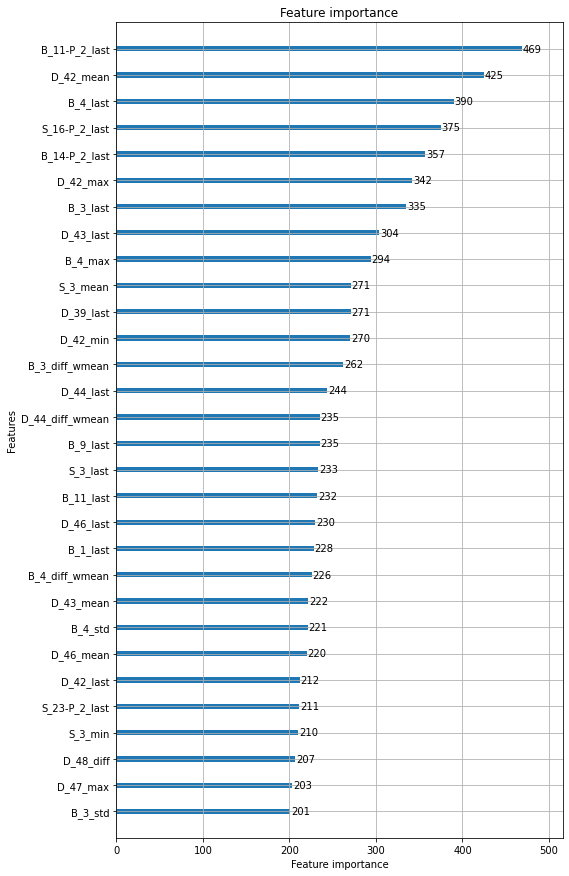

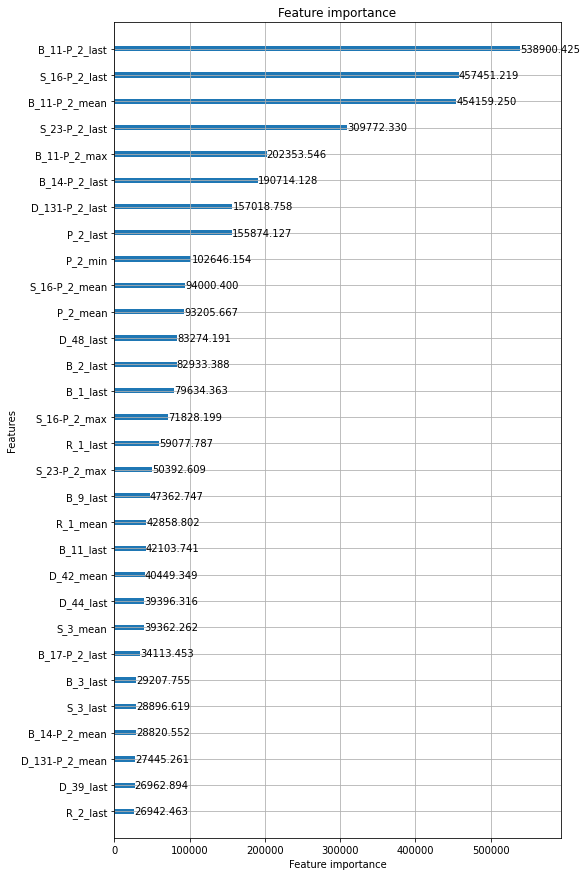

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.750605	valid_0's recall_at4: 0.601894	valid_0's norm_gini: 0.899317


[100]	valid_0's amex_metric: 0.76087	valid_0's recall_at4: 0.616874	valid_0's norm_gini: 0.904866


[150]	valid_0's amex_metric: 0.76715	valid_0's recall_at4: 0.625458	valid_0's norm_gini: 0.908843


[200]	valid_0's amex_metric: 0.773603	valid_0's recall_at4: 0.634715	valid_0's norm_gini: 0.912492


[250]	valid_0's amex_metric: 0.778508	valid_0's recall_at4: 0.642289	valid_0's norm_gini: 0.914728


[300]	valid_0's amex_metric: 0.780796	valid_0's recall_at4: 0.645235	valid_0's norm_gini: 0.916357


[350]	valid_0's amex_metric: 0.783449	valid_0's recall_at4: 0.649358	valid_0's norm_gini: 0.91754


[400]	valid_0's amex_metric: 0.78511	valid_0's recall_at4: 0.651673	valid_0's norm_gini: 0.918547


[450]	valid_0's amex_metric: 0.785906	valid_0's recall_at4: 0.652514	valid_0's norm_gini: 0.919298


[500]	valid_0's amex_metric: 0.786944	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.919817


[550]	valid_0's amex_metric: 0.787254	valid_0's recall_at4: 0.654197	valid_0's norm_gini: 0.920311


[600]	valid_0's amex_metric: 0.787386	valid_0's recall_at4: 0.654155	valid_0's norm_gini: 0.920617


[650]	valid_0's amex_metric: 0.788093	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.920978


[700]	valid_0's amex_metric: 0.78834	valid_0's recall_at4: 0.655418	valid_0's norm_gini: 0.921263


[750]	valid_0's amex_metric: 0.788669	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.9215


[800]	valid_0's amex_metric: 0.788756	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.921675


[850]	valid_0's amex_metric: 0.789686	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.921935


[900]	valid_0's amex_metric: 0.790255	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.922104


[950]	valid_0's amex_metric: 0.790043	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.922353


[1000]	valid_0's amex_metric: 0.790088	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.922571


[1050]	valid_0's amex_metric: 0.790717	valid_0's recall_at4: 0.658658	valid_0's norm_gini: 0.922776


[1100]	valid_0's amex_metric: 0.791096	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.922988


[1150]	valid_0's amex_metric: 0.791668	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.923121


[1200]	valid_0's amex_metric: 0.791676	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.923264


[1250]	valid_0's amex_metric: 0.791975	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923357


[1300]	valid_0's amex_metric: 0.79206	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.923443


[1350]	valid_0's amex_metric: 0.791962	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.923498


[1400]	valid_0's amex_metric: 0.791758	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.923595


[1450]	valid_0's amex_metric: 0.792288	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.923646


[1500]	valid_0's amex_metric: 0.792413	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.923727


[1550]	valid_0's amex_metric: 0.793331	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.923838


[1600]	valid_0's amex_metric: 0.793404	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.923901


[1650]	valid_0's amex_metric: 0.793224	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923961


[1700]	valid_0's amex_metric: 0.792746	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.924014


[1750]	valid_0's amex_metric: 0.79293	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.924088


[1800]	valid_0's amex_metric: 0.793135	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.92412


[1850]	valid_0's amex_metric: 0.793508	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.92415


[1900]	valid_0's amex_metric: 0.793336	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924185


[1950]	valid_0's amex_metric: 0.793196	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.924242


[2000]	valid_0's amex_metric: 0.793599	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924289


[2050]	valid_0's amex_metric: 0.793398	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924309


[2100]	valid_0's amex_metric: 0.793183	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924342


[2150]	valid_0's amex_metric: 0.793793	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.924384


[2200]	valid_0's amex_metric: 0.793414	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.924425


[2250]	valid_0's amex_metric: 0.794004	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.92447


[2300]	valid_0's amex_metric: 0.793724	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.924499


[2350]	valid_0's amex_metric: 0.793583	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.924511


[2400]	valid_0's amex_metric: 0.793791	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924548


[2450]	valid_0's amex_metric: 0.794248	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924537


[2500]	valid_0's amex_metric: 0.793708	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.924551


[2550]	valid_0's amex_metric: 0.794014	valid_0's recall_at4: 0.663497	valid_0's norm_gini: 0.924532


[2600]	valid_0's amex_metric: 0.794202	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924528


[2650]	valid_0's amex_metric: 0.794308	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.92453


[2700]	valid_0's amex_metric: 0.794327	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924526


[2750]	valid_0's amex_metric: 0.794484	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924545


[2800]	valid_0's amex_metric: 0.794494	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924566


[2850]	valid_0's amex_metric: 0.794101	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924578


[2900]	valid_0's amex_metric: 0.794252	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924587


[2950]	valid_0's amex_metric: 0.794359	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.92459


[3000]	valid_0's amex_metric: 0.794348	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.92461


[3050]	valid_0's amex_metric: 0.794073	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.924608


[3100]	valid_0's amex_metric: 0.794013	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.924614


[3150]	valid_0's amex_metric: 0.794026	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.924639


[3200]	valid_0's amex_metric: 0.793903	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.924646


[3250]	valid_0's amex_metric: 0.794338	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.924631


[3300]	valid_0's amex_metric: 0.794468	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.92464


[3350]	valid_0's amex_metric: 0.794735	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.924627


[3400]	valid_0's amex_metric: 0.794786	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924644


[3450]	valid_0's amex_metric: 0.794414	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924658


[3500]	valid_0's amex_metric: 0.794758	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.924672


[3550]	valid_0's amex_metric: 0.794135	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.92469


[3600]	valid_0's amex_metric: 0.794417	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924707


[3650]	valid_0's amex_metric: 0.794468	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924724


[3700]	valid_0's amex_metric: 0.794163	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.924745


[3750]	valid_0's amex_metric: 0.794658	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924767


[3800]	valid_0's amex_metric: 0.79448	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924791


[3850]	valid_0's amex_metric: 0.794933	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.924812


[3900]	valid_0's amex_metric: 0.794667	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924828


[3950]	valid_0's amex_metric: 0.794865	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.924845


[4000]	valid_0's amex_metric: 0.795057	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.924851


[4050]	valid_0's amex_metric: 0.794971	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.924846


[4100]	valid_0's amex_metric: 0.79505	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.924837


[4150]	valid_0's amex_metric: 0.794628	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924833


[4200]	valid_0's amex_metric: 0.794635	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924848


[4250]	valid_0's amex_metric: 0.794675	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924843


[4300]	valid_0's amex_metric: 0.794705	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924861


[4350]	valid_0's amex_metric: 0.794938	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924865


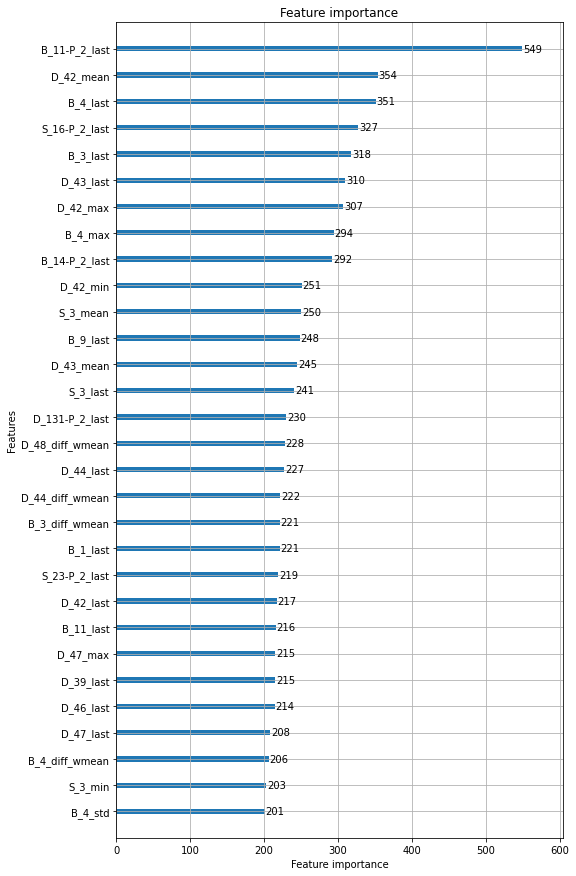

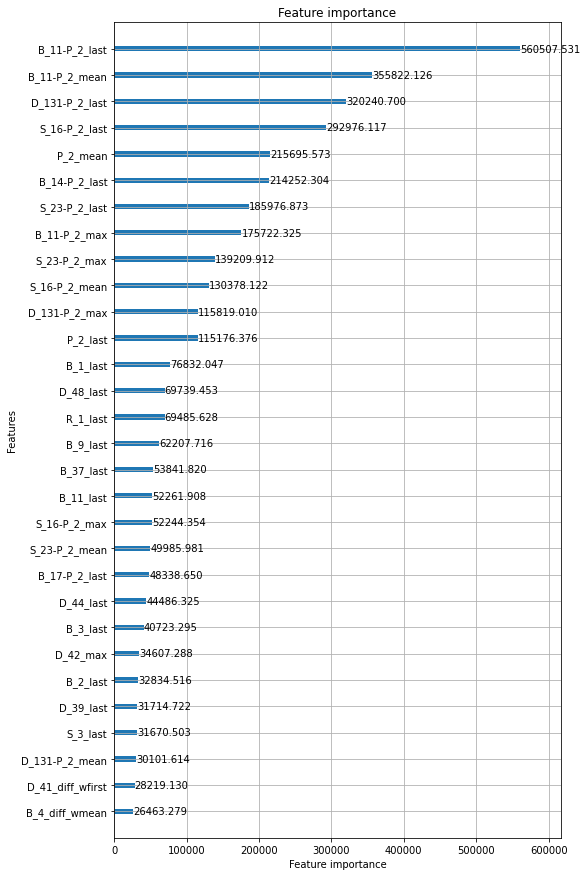

Training time: 53.539520263671875 min.
OOF recall_at4: 0.6675531019625004
OOF normalized_gini: 0.9257674464512297
OOF competition metric: 0.796660274206865


CPU times: user 1d 9h 53min 18s, sys: 1min 31s, total: 1d 9h 54min 50s
Wall time: 2h 39min 55s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.668201,0.925624,0.796912
1,0.669085,0.925574,0.797329
2,0.667553,0.925767,0.796660



mean:


recall_at4    0.668280
gini          0.925655
metric        0.796967
dtype: float64


std:


recall_at4    0.000769
gini          0.000100
metric        0.000338
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 1h 56min 54s, sys: 1min 4s, total: 1h 57min 59s
Wall time: 10min 29s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.67 s, sys: 845 ms, total: 4.52 s
Wall time: 4.51 s


***